# **Loan Default Prediction**

## **Problem Definition**

### **The Context:**

Loan defaults pose a significant threat to a bank’s financial health. For instance, while the mortgage delinquency rate in the United States has been gradually declining since the COVID-19 pandemic, as of February 2024, the overall delinquency rate was 2.8%. Such non-performing assets (NPAs) erode profitability and constrain the bank’s ability to extend new credit. Moreover, the manual loan approval process is labor-intensive and susceptible to human errors and biases, leading to potential misjudgments in loan approvals or rejections. Addressing this issue is crucial to enhance operational efficiency, reduce financial risks, and uphold equitable lending practices.

### **The objective:**

The goal is to modernize and streamline the loan approval process by leveraging machine learning classification methods, capable of as accurately predicting loan defaults as possible using available data. This model should:
 - Enhance operational efficiency by automating repetitive tasks and reducing the time spent on manual credit assessments.
 - Mitigate risk by identifying high-risk applicants before loan issuance.
 - Ensure fairness by eliminating biases that could disadvantage certain demographics, thus aligning with federal regulation, legal requirements and ethical standards.
 - Ensure Regulatory Compliance by aligning with legal frameworks such as the Equal Credit Opportunity Act, which mandates non-discriminatory lending practices and requires transparent justifications for adverse decisions.
 - Enable data-driven decision-making by providing interpretable insights into why a loan is approved or rejected, allowing for greater transparency and trust with stakeholders.
 - Promote Fairness by eliminating biases inherent in human judgment, ensuring equitable treatment of all applicants.
 - The model should be extensible to learn from future loan defaults

### **The key questions:**

 - Which applicants are likely to default on their loans? Identifying potential defaulters enables targeted risk management strategies.
 - What factors are most critical in assessing an applicant’s creditworthiness? Determining key indicators such as income stability, debt-to-income ratio, and credit history informs more accurate evaluations.
 - How can the loan approval process be optimized for efficiency and fairness? Implementing automated, data-driven systems can streamline operations while upholding ethical standards.
 - How can the model ensure compliance with regulatory requirements? Providing interpretable justifications for loan decisions is essential to meet legal obligations and maintain transparency.
 - How can historical biases be prevented from influencing the model? Ensuring the model is trained on unbiased data is crucial to avoid perpetuating past discriminatory practices.

### **The problem formulation**:

Data science enables us to:
 - Predict defaults: Use predictive analytics to assess the likelihood of applicants failing to meet their repayment obligations.
 - Automate Decision-Making: Replace subjective human assessments with objective, data-driven evaluations, enhancing consistency and speed.
 - Identify Key Risk Factors: Analyze data to pinpoint variables that significantly influence default risk, such as high debt-to-income ratios or unstable employment histories.
 - Ensure Model Interpretability: Develop transparent models that provide clear explanations for their decisions, facilitating compliance with regulations and building stakeholder trust.
 - Mitigate Bias: Implement fairness algorithms to detect and correct biases, ensuring the model’s decisions are equitable and just.

By solving this problem, the bank not only reduces risk but also transforms its loan approval system into a benchmark for innovation and inclusivity.

## **Data Description:**
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property. 

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts) 

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments). 

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due). 

* **CLAGE:** Age of the oldest credit line in months. 

* **NINQ:** Number of recent credit inquiries. 

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

## **Import the necessary libraries and Data**

In [73]:
# Start time
import time
script_start_time = time.time()

# Ignore warning messages only
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning

# Suppress only ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# garbage collection
import gc
import copy

# Importing the Pandas library for data manipulation and analysis
import pandas as pd

# Importing the NumPy library for numerical operations
import numpy as np
import math

# Importing Matplotlib for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Importing train_test_split function to split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Importing Logistic Regression model from scikit-learn for binary classification
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

# Importing Decision Tree Classifier from scikit-learn for classification tasks
from sklearn.tree import DecisionTreeClassifier

# Importing Random Forest Classifier from scikit-learn for ensemble learning
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fancyimpute import KNN
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, make_scorer, f1_score
from itertools import combinations
from scipy.stats import chi2_contingency

In [74]:
# Functions for use in the main code

# Data processing functions
def summarize_dataframe(sdf):
    """
    Summarizes the structure and content of a DataFrame.
    """
    return pd.DataFrame({
        'Column': sdf.columns,
        'Non-Null Count': sdf.notnull().sum(),
        'Data Type': sdf.dtypes,
        'Unique Values': sdf.nunique(),
        'Missing Values': sdf.isnull().sum(),
        'Missing Values %': ((sdf.isnull().sum()*100)/len(sdf)).round(2)
    }).reset_index(drop=True)


def impute_missing_values(df):
    """
    Imputes missing values in a dataset using KNN for low/moderate missingness 
    and Iterative Imputer for high missingness. Categorical columns are encoded 
    using LabelEncoder and can be converted back to their original values.

    Parameters:
    df (pd.DataFrame): The input dataset with missing values.

    Returns:
    pd.DataFrame: The dataset with missing values imputed.
    dict: A dictionary of LabelEncoder objects for categorical columns.
    """

# Column segregation
    columns_knn = [
        'mortgage_amount_due', 'property_current_value',
        'loan_request_reason', 'applicant_job_type',
        'age_of_oldest_credit_line', 'existing_credit_lines'
    ]
    columns_iterative = [
        'debt_to_income_ratio', 'major_derogatory_reports',
        'delinquent_credit_lines', 'years_at_present_job',
        'recent_credit_inquiries'
    ]
    
    # Encode categorical columns for KNN
    categorical_columns = ['loan_request_reason', 'applicant_job_type']
    # Convert object columns to category dtype before encoding
    original_categories = {}
    for col in categorical_columns:
        df[col] = df[col].astype('category')  # Convert to category
        original_categories[col] = df[col].cat.categories  # Save the original categories

    for col in categorical_columns:
        df[col] = df[col].astype('category').cat.codes.replace(-1, np.nan)  # Encode categories and handle NaN
    
    # Impute with KNN
    knn_imputer = KNN(k=5, verbose=False)
    df[columns_knn] = knn_imputer.fit_transform(df[columns_knn])
    
    # Impute with IterativeImputer
    iterative_imputer = IterativeImputer(max_iter=10, random_state=42, verbose=0)
    df[columns_iterative] = iterative_imputer.fit_transform(df[columns_iterative])

    # Return the fully imputed dataset and label encoders
    return df, original_categories


def decode_categorical_columns(df, label_encoders):
    """
    Decodes categorical columns back to their original values using LabelEncoder objects.

    Parameters:
    df (pd.DataFrame): The DataFrame with encoded categorical columns.
    label_encoders (dict): A dictionary of LabelEncoder objects for each categorical column.

    Returns:
    pd.DataFrame: The DataFrame with categorical columns decoded to their original values.
    """
    df_decoded = df.copy()
    for col, le in label_encoders.items():
        df_decoded[col] = le.inverse_transform(df_decoded[col].astype(int))
    return df_decoded


def calculate_corr_and_vif(input_data, target):
    """
    Calculate the correlation matrix and Variance Inflation Factor (VIF)
    for numerical predictor columns in a given DataFrame, excluding the target variable.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.
    target_variable (str): The name of the target variable to exclude.

    Returns:
    tuple: A tuple containing the correlation matrix (pd.DataFrame)
           and VIF values (pd.DataFrame).
    """
    # Copy the dataset
    dataframe = input_data.copy()
    
    # Drop the target variable
    dataframe.drop(target, axis=1, inplace=True)
    
    # Select only numerical columns
    numeric_df = dataframe.select_dtypes(include=[np.number])
    
    # Calculate the correlation matrix
    corr_matrix = numeric_df.corr()
    
    # Calculate VIF for each numerical column
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(numeric_df.values, i)
        for i in range(numeric_df.shape[1])
    ]
    
    return corr_matrix, vif_data


# Data visualization functions


def plot_grouped_barplots(data, features, target, figsize=(15, 6)):
    """
    Plots grouped barplots for a list of features against a target variable.

    Parameters:
        data (pd.DataFrame): The input dataset.
        features (list): List of features to group by.
        target (str): The target variable to sum for each group.
        figsize (tuple): Size of each subplot figure. Default is (15, 6).

    Returns:
        None: Displays the plots.
    """
    # Determine grid size for subplots
    num_features = len(features)
    n_cols = 3  # Number of columns per row
    n_rows = math.ceil(num_features / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Iterate over features and create barplots
    for i, feature in enumerate(features):
        # Group and sum data
        summed_data = data.groupby(feature)[target].sum().reset_index()

        # Create barplot
        sns.barplot(x=feature, y=target, data=summed_data, ax=axes[i])
        axes[i].set_title(f'Sum of {target} by {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(f'Sum of {target}')
        axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability
        total = summed_data[target].sum()
        for bar in axes[i].patches:
            height = bar.get_height()
            percentage = (height / total) * 100  # Calculate percentage
            if percentage > 0:
                axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)
        sns.despine()

    # Turn off any unused subplots
    for j in range(num_features, len(axes)):
        axes[j].axis('off')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


def histogram_boxplot(data, feature, figsize=(12, 7), kde=True, bins=None):
    """
    Boxplot and histogram combined with automatic bins and x-axis ticks.
    Ensures the x-axis starts at zero.

    Parameters:
    - data: DataFrame
    - feature: Column in the DataFrame
    - figsize: Size of the figure (default (12, 7))
    - kde: Whether to show density curve (default True)
    - bins: Number of bins or sequence of bin edges for histogram (default None)
    """

    # Create the subplots for boxplot and histogram
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,      # Number of rows of the subplot grid = 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )

    # Boxplot with the mean indicated
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="violet")

    # Calculate automatic bins if not provided
    if bins is None:
        q75, q25 = data[feature].quantile([0.75, 0.25])  # Interquartile range
        iqr = q75 - q25
        if len(data[feature]) == 0:  # Handle empty feature
            raise ValueError(f"Feature '{feature}' contains no data.")
        if data[feature].max() - data[feature].min() == 0:  # Handle zero range
            bins = 1
        else:
            bin_width = 2 * iqr / (len(data[feature]) ** (1 / 3))
            if bin_width <= 0:  # Handle zero or negative bin width
                bin_width = 1  # Default fallback
            bins = int((data[feature].max() - data[feature].min()) / bin_width)
            bins = max(1, bins)  # Ensure at least 1 bin

    # Create the histogram
    sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, color="blue")

    # Add mean and median to the histogram
    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--", label="Mean")
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-", label="Median")
    ax_hist2.legend()

    # Ensure x-axis starts at 0
    ax_hist2.set_xlim(left=0)  # Set the minimum x-axis value to 0

    # Automatically adjust x-axis ticks
    x_min, x_max = ax_hist2.get_xlim()  # Get the updated limits of the x-axis
    ticks = np.linspace(x_min, x_max, num=10)  # Generate evenly spaced ticks
    ax_hist2.set_xticks(ticks)  # Set the new ticks

    plt.show()


def plot_barplots(data, variables, target_variable, nrows=3, ncols=2, figsize=(18, 10)):
    """
    Create bar plots showing the sum of a target variable grouped by each variable in the list.

    Parameters:
    - data (DataFrame): The DataFrame containing the data.
    - variables (list): List of variables to plot.
    - target_variable (str): The target variable to aggregate.
    - nrows (int): Number of rows in the subplot grid.
    - ncols (int): Number of columns in the subplot grid.
    - figsize (tuple): Figure size for the plot.
    """
    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten the array for easier indexing

    for i, var in enumerate(variables):
        if i >= len(axes):
            break  # Avoid indexing errors if there are more variables than subplots

        # Calculate the sum of the target variable for each category of the variable
        var_sums = data.groupby(var)[target_variable].sum().reset_index()

        # Create the barplot
        sns.barplot(x=var, y=target_variable, data=var_sums, ax=axes[i])
        axes[i].set_title(f'Sum of {target_variable} by {var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(f'Sum of {target_variable}')
        axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

    # Remove any extra subplots if the number of variables is less than the grid size
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


def plot_binned_features(data, features, status, bins=5, title=None):
    """
    Plots subplots for binned bar charts of multiple features against a status variable.

    Parameters:
        data (pd.DataFrame): The dataset containing the features and status.
        features (list): A list of continuous variables to be binned and plotted.
        status (str): The variable to sum for each bin, plotted on the y-axis.
        bins (int): Number of bins to create for the features.
        title (str, optional): Title of the overall plot. Default is None.

    Returns:
        None: Displays the subplots.
    """
    # Calculate the grid dimensions
    n_rows, n_cols = 6, 2  # Fixed 4 rows and 3 columns
    total_subplots = n_rows * n_cols
    num_features = len(features)

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))
    fig.suptitle(title if title else f"Features vs {status}", fontsize=16)

    # Flatten axes for easy indexing
    axes = axes.flatten()

    # Iterate over features and create plots
    for i, feature in enumerate(features):
        ax = axes[i]

        # Group by feature and calculate the sum of the status variable
        grouped_data = data.groupby(feature)[status].sum().reset_index()

        # Create bins for the feature
        grouped_data['feature_bin'] = pd.cut(grouped_data[feature], bins=bins)

        # Group by bins and calculate the sum of the status variable
        binned_data = grouped_data.groupby('feature_bin')[status].sum().reset_index()

        # Generate bin labels
        bin_edges = grouped_data['feature_bin'].cat.categories
        bin_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in bin_edges]

        # Bar plot
        sns.barplot(data=binned_data, x='feature_bin', y=status, ax=ax)

        # Add title and labels
        ax.set_title(f"{feature} vs {status}")
        ax.set_xlabel(f"{feature}")
        ax.set_ylabel(f"{status}")

        # Set x-axis tick labels
        ax.set_xticks(range(len(bin_labels)))
        ax.set_xticklabels(bin_labels, rotation=45)
        total = grouped_data[status].sum()
        for bar in ax.patches:
            height = bar.get_height()
            percentage = (height / total) * 100  # Calculate percentage
            if percentage > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)
        sns.despine()

    # Turn off extra subplots
    for i in range(num_features, total_subplots):
        axes[i].axis('off')

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_feature_importance(importances, columns):
    """
    Plots feature importances as a bar chart.

    Args:
      importances: A list or array of feature importances.
      columns: A list of feature names corresponding to the importances.
    """

    # Create a DataFrame for the feature importances
    importance_df = pd.DataFrame(importances, index=columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(13, 13))
    sns.barplot(x=importance_df.Importance, y=importance_df.index, palette="magma") 
    plt.title("Feature Importances", fontsize=16)
    plt.xlabel("Importance", fontsize=14)
    plt.ylabel("Features", fontsize=14)
    plt.show()


def visualize_decision_tree(dt, X, max_depth=4):
    """
    Visualizes a decision tree using matplotlib.

    Args:
      dt: The trained decision tree model.
      X: The DataFrame or array containing the features used for training.
      max_depth (int): The maximum depth of the tree to display (default: 4).
    """

    plt.figure(figsize=(30, 20))
    plot_tree(dt, 
              max_depth=max_depth, 
              feature_names=list(X.columns), 
              filled=True, 
              fontsize=12, 
              node_ids=True, 
              class_names=None)
    plt.show()


def plot_distributions(column, original_data, imputed_data):
    """
    Plots the distributions of a feature before and after imputation.

    Parameters:
    column (str): The column name to plot.
    original_data (DataFrame): The original dataset with missing values.
    imputed_data (DataFrame): The dataset after imputation.
    """
    plt.figure(figsize=(10, 6))
    sns.kdeplot(original_data[column], label="Before Imputation", fill=True, alpha=0.5, color="blue")
    sns.kdeplot(imputed_data[column], label="After Imputation", fill=True, alpha=0.5, color="green")
    plt.title(f'Distribution of {column}: Before vs. After Imputation', fontsize=14)
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_correlation_heatmap(data, title):
    """
    Plots the correlation heatmap of the dataset.

    Parameters:
    data (DataFrame): The dataset to plot.
    title (str): The title of the heatmap.
    """
    plt.figure(figsize=(12, 10))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(title, fontsize=16)
    plt.show()


def plot_missingness_heatmap(data, title):
    """
    Plots a heatmap of missing values in the dataset.

    Parameters:
    data (DataFrame): The dataset to plot.
    title (str): The title of the heatmap.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
    plt.title(title, fontsize=16)
    plt.show()


# Model evaluation functions


def metrics_score(actual, predicted):
    """
    Calculates and displays classification metrics and confusion matrix.
    """
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=['Not defaulted', 'Defaulted'],
                yticklabels=['Not Defaulted', 'Defaulted'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier

    predictors: independent variables

    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    recall = recall_score(target, pred,average = 'macro')                 # To compute recall

    precision = precision_score(target, pred, average = 'macro')              # To compute precision

    acc = accuracy_score(target, pred)                                 # To compute accuracy score


    # Creating a dataframe of metrics

    df_perf = pd.DataFrame(
        {
            "Precision":  precision,
            "Recall":  recall,
            "Accuracy": acc,
        },

        index = [0],
    )

    return df_perf


def chi_squared_test(data, target, bins=5):
    """
    Perform the Chi-Squared test for independence between all features
    and the target variable, handling both categorical and continuous features.

    Parameters:
        data (pd.DataFrame): The input dataset.
        target (str): The name of the target variable.
        bins (int): Number of bins to discretize continuous features. Default is 5.

    Returns:
        pd.DataFrame: A DataFrame containing features, their P-values, 
                      and whether they are significant.
    """
    # Separate target column
    target_data = data[target]
    features = data.drop(columns=[target])

    # List to store results for each feature
    results = []

    for feature in features.columns:
        if features[feature].dtype in ['object', 'category']:
            # Categorical feature: Use directly
            feature_data = features[feature]
        else:
            # Continuous feature: Discretize into bins
            feature_data = pd.cut(features[feature], bins=bins, labels=False)

        # Create a contingency table for the current feature and target
        contingency_table = pd.crosstab(feature_data, target_data)

        # Perform the Chi-Squared test for independence
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Append the feature and p-value to the results list
        results.append({'Feature': feature, 'P-value': p, 'Significant': p < 0.05})

    # Convert results to a DataFrame for better visualization
    results_df = pd.DataFrame(results)

    # Sort the results by P-value in ascending order
    sorted_results = results_df.sort_values(by='P-value', ascending=True)

    return sorted_results


# General utilities functions


def segregate_columns_by_dtype(df):
    """
    Segregates DataFrame columns by their data types.
    """
    return {dtype.name: df.select_dtypes(include=[dtype]).columns.tolist() for dtype in df.dtypes.unique()}


def calculate_expected_with_confidence(original_data, loan_value, interest_rate=0.085):
    """
    Calculate expected profit, explicitly accounting for FP, FN, and confidence.

    Parameters:
    - original_data: pd.DataFrame, containing 'prob_default', 'actual', and loan value columns.
    - loan_value: str, name of the column containing loan values.
    - interest_rate: float, interest rate applied to loans (default: 8.5%).

    Returns:
    - float: Total expected profit with confidence-adjusted revenue.
    - float: Average confidence level.
    """
    # Add P(non-default) = 1 - P(default) to the dataset
    original_data['prob_non_default'] = 1 - original_data['prob_default']
    
    # Calculate confidence scores
    original_data['confidence'] = original_data[['prob_non_default', 'prob_default']].max(axis=1)
    
    # Revenue from True Negatives (TN): Correctly predicted non-defaults
    original_data['revenue_tn'] = (
        original_data['prob_non_default'] 
        * (1 - original_data['client_defaulted_on_loan']) 
        * original_data['confidence']  # Adjust by confidence
        * original_data[loan_value] 
        * interest_rate
    )
    
    # Loss from False Positives (FP): Predicted default but actual non-default
    original_data['loss_fp'] = (
        original_data['prob_default'] 
        * (1 - original_data['client_defaulted_on_loan']) 
        * (1 - original_data['confidence'])  # Adjust by lack of confidence
        * original_data[loan_value] 
        * interest_rate
    )
    
    # Loss from False Negatives (FN): Predicted non-default but actual default
    original_data['loss_fn'] = (
        original_data['prob_non_default'] 
        * original_data['client_defaulted_on_loan'] 
        * (1 - original_data['confidence'])  # Adjust by lack of confidence
        * original_data[loan_value] 
        * (1 + interest_rate)
    )
    
    # Calculate total profit
    total_profit = original_data['revenue_tn'].sum() - original_data['loss_fp'].sum() - original_data['loss_fn'].sum()
    
    # Calculate average confidence
    avg_confidence = original_data['confidence'].mean()
    
    return total_profit, avg_confidence


# Plot explained variance ratio
def plot_pca(pca_object):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.grid()
    plt.show()

## **Data Overview**
- Reading the dataset
- Understanding the shape of the dataset
- Checking the data types
- Checking for missing values
- Checking for duplicated values

In [75]:
# Import data from CSV file into a Pandas DataFrame
df = pd.read_csv('../data/hmeq.csv')

In [76]:
# Make a copy of the original dataframe for processing, so the original data stays intact
default = df.copy()

In [77]:
# Update column names for improved readability
default.rename(columns={
    'BAD': 'client_defaulted_on_loan',  # 1 = Client defaulted on loan, 0 = loan repaid
    'LOAN': 'loan_amount_approved',      # Amount of loan approved
    'MORTDUE': 'mortgage_amount_due',    # Amount due on the existing mortgage
    'VALUE': 'property_current_value',    # Current value of the property
    'REASON': 'loan_request_reason',      # Reason for the loan request
    'JOB': 'applicant_job_type',          # Type of job that loan applicant has
    'YOJ': 'years_at_present_job',        # Years at present job
    'DEROG': 'major_derogatory_reports',  # Number of major derogatory reports
    'DELINQ': 'delinquent_credit_lines',  # Number of delinquent credit lines
    'CLAGE': 'age_of_oldest_credit_line',  # Age of the oldest credit line in months
    'NINQ': 'recent_credit_inquiries',     # Number of recent credit inquiries
    'CLNO': 'existing_credit_lines',       # Number of existing credit lines
    'DEBTINC': 'debt_to_income_ratio'      # Debt-to-income ratio
}, inplace=True)

In [78]:
# Check the shape of the dataset
default.shape

(5960, 13)

In [79]:
# Use the summarize_dataframe function and display the summary
summarize_dataframe(default)

,Column,Non-Null Count,Data Type,Unique Values,Missing Values,Missing Values %
0,client_defaulted_on_loan,5960,int64,2,0,0.00
1,loan_amount_approved,5960,int64,540,0,0.00
2,mortgage_amount_due,5442,float64,5053,518,8.69
3,property_current_value,5848,float64,5381,112,1.88
4,loan_request_reason,5708,object,2,252,4.23
5,applicant_job_type,5681,object,6,279,4.68
6,years_at_present_job,5445,float64,99,515,8.64
7,major_derogatory_reports,5252,float64,11,708,11.88
8,delinquent_credit_lines,5380,float64,14,580,9.73
9,age_of_oldest_credit_line,5652,float64,5314,308,5.17


In [80]:
# Check for duplicates and drop if found
num_duplicates = default.duplicated().sum()  # Count duplicates

if num_duplicates > 0:
    print(f"Number of duplicate rows: {num_duplicates}")
    default.drop_duplicates(keep='first', inplace=True)  # Drop duplicates, keeping the first
    print(len(df) - len(default), "Duplicate rows dropped (keeping the first occurrence).")
    default.reset_index(drop=True, inplace=True)  # Reset index after dropping duplicates
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [81]:
# Iterate through each non-numeric column and print its unique values
for column in default.select_dtypes(include=['object']):
    print(f"{column}: {default[column].value_counts()}")

loan_request_reason: loan_request_reason
DebtCon    3928
HomeImp    1780
Name: count, dtype: int64
applicant_job_type: applicant_job_type
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: count, dtype: int64


#### Let's check any inconsitencies in the data

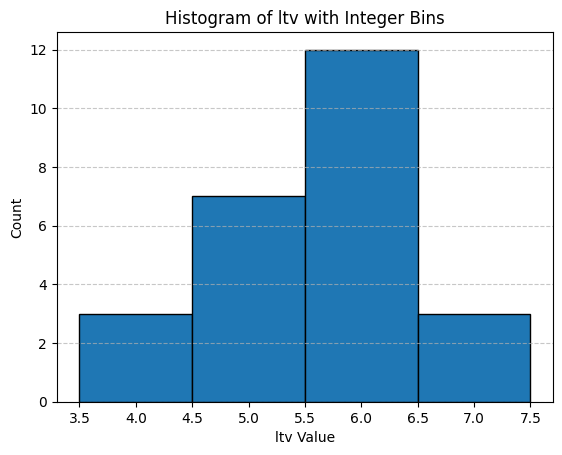

In [82]:
# Check for inconsisties in the data
# Typical mortgage to property value ratio is ~ 0.8. Lets confirm it
default['ltv'] = default['mortgage_amount_due'] / default['property_current_value']  # create a column ltv (loan to value ratio)
high_ltv = default[default['ltv'] >= 2]  # Create a temp dataframe of rows with ltv > 2

# Plot the count of clients with ltv greater than 2.
plt.hist(high_ltv['ltv'], bins=np.arange(int(high_ltv['ltv'].min()), int(high_ltv['ltv'].max()) + 2) - 0.5, edgecolor='black')
plt.xlabel('ltv Value')
plt.ylabel('Count')
plt.title('Histogram of ltv with Integer Bins')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [83]:
# Drop all records with ltv greater than or equal to 2 and the ltv column as it is no longer necessary
default.drop(default[default['ltv'] >= 2].index, axis=0, inplace=True)
default.drop('ltv', axis=1, inplace=True)

In [84]:
# delete the temporary dataframe
del high_ltv
# Trigger garbage collection and print the number of objects collected
collected_objects = gc.collect()
print(f"Garbage collector freed {collected_objects} objects.")

Garbage collector freed 13858 objects.


#### Observations
1. Dataset contains several missing values. These need to be treated individually as the use of summary statistic may not be appropriate or sufficient for this this dataset i.e. morgage_amount_due can have missing values,but loan_request_reason or property_current_value cannot be. Also many of the missing values may depend on values in other columns, such as major_derogatory_report, delinquent_credit_lines, recent_credit_inquiries, existing_credit_lines and debt_to_income_ratio are all correlated
2. Features like debt_to_income_ratio and major_derogatory_reports have significant missing values (21.3% and 11.9%, respectively)
4. Dataset has 5960 rows and 13 columns (12 independant features)
5. Data is for approved loans only, as there are no missing values in the loan_amount_approved
6. No duplicate records, which is understandable, as most individuals or families requesting for loan are unique
7. All categorical values look clean - no typos, unique values and consistent labeling
8. Many of the features should be integrers, but are floats in the dataset - major_derogatory_reports, delinquent_credir_lines, recent_credit_inquiries and existing_credit_lines. If the actual values, indeed are floats, its a data descripency which should be addresses before further processing
9. Proportion of defaulting client is 20%, which is too high by industry standards, indicating a highly biased dataset
10. Several records had a very high loan to value ratio. This is quite unusual. All the records with ltv > 2.0 were dropped
11. Also, the features applicant job type and years at present job, may invite discimatory litigation (class action lawsuits)!

## Summary Statistics

In [85]:
# Review the key statistics of the data, transposed for better readability
default.describe().T

,count,mean,std,min,25%,50%,75%,max
client_defaulted_on_loan,5935.0,0.200168,0.400160,0.000000,0.000000,0.000000,0.000000,1.000000
loan_amount_approved,5935.0,18561.988206,11200.374986,1100.000000,11000.000000,16300.000000,23200.000000,89900.000000
mortgage_amount_due,5417.0,73262.529297,43603.499047,2063.000000,46145.000000,65000.000000,91165.000000,399550.000000
property_current_value,5823.0,102076.174659,57318.611176,8800.000000,66356.000000,89508.000000,120076.500000,855909.000000
years_at_present_job,5420.0,8.948847,7.580495,0.000000,3.000000,7.000000,13.000000,41.000000
major_derogatory_reports,5234.0,0.255445,0.847369,0.000000,0.000000,0.000000,0.000000,10.000000
delinquent_credit_lines,5362.0,0.446475,1.127495,0.000000,0.000000,0.000000,0.000000,15.000000
age_of_oldest_credit_line,5627.0,179.837880,85.884097,0.000000,115.133546,173.214284,231.976301,1168.233561
recent_credit_inquiries,5425.0,1.181014,1.728654,0.000000,0.000000,1.000000,2.000000,17.000000
existing_credit_lines,5713.0,21.217574,10.041934,0.000000,14.000000,20.000000,26.000000,71.000000


#### Observations

1. Skewness: major_derogatory_reports, delinquent_credit_lines, debt_to_income_ratio are concentrated near zero with a long tail, indicating skewness
2. Outliers: mortgage_amount_due, property_current_value, age_of_oldest_credit_line, and debt_to_income_ratio extreme high max values, with 75% percentile closer to the mean, indicating outliers.

Vizualization of the distributions of these features will provide clarity on these observations.

## **Exploratory Data Analysis (EDA) and Visualization**

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. What is the range of values for the loan amount variable "LOAN"?
2. How does the distribution of years at present job "YOJ" vary across the dataset?
3. How many unique categories are there in the REASON variable?
4. What is the most common category in the JOB variable?
5. Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?
6. Do applicants who default have a significantly different loan amount compared to those who repay their loan?
7. Is there a correlation between the value of the property and the loan default rate?
8. Do applicants who default have a significantly different mortgage amount compared to those who repay their loan?

### **Data prep for EDA and subsequent processing**

#### Missing value treatement
I have used techniques from recommandation systems to impute the missing values **(Reference: "Missing Data: A Gentle Introduction" by Patrick E. McKnight, Katherine M. McKnight, Souraya Sidani, and Aurelio José Figueredo)**. Below is a summary of methods used for imputatation

**1. KNN Imputation (Low/Moderate Missingness)**

* mortgage_amount_due, property_current_value, loan_request_reason, applicant_job_type, age_of_oldest_credit_line, existing_credit_line columns have less than 10% missing values. KNN imputation is effective for low-to-moderate missingness by finding similar rows based on available features and averaging/matching the corresponding feature values.

**2. Iterative Imputer (High Missingness)**

* debt_to_income_ratio, major_derogatory_reports, delinquentt_credit_line, years_at_present_job, recent_credit_inquirie columns have higher missing percentages (10–21%). Iterative imputation models each feature as a function of the others, iteratively predicting missing values to best fit the observed data.

**3. Encoding for Categorical Data**

* loan_request_reason, applicant_job_type columns contain categorical data. They were encoded using LabelEncoder to convert string values into numeric categories, allowing compatibility with KNN imputer.

In [86]:
# Treat missing values using the custom function 'impute_missing_values', which implements the KNN and Iterative imputation based on % missing values for each column
default_imputed_num, categories = impute_missing_values(default)

# Upon inspection of the dataset after imputation, it is observed that in some of the rows, property value and mortgage due were imputed to 0. These zero values were set to the median value of the column
for col in ['property_current_value', 'mortgage_amount_due']:
    median_value = default_imputed_num[col].median()
    default_imputed_num.loc[default_imputed_num[col] == 0, col] = median_value

In [87]:
# Create a copy of the imputed data in numeric format (could be of use later!)
default_imputed = default_imputed_num.copy()

# Convert categorical columns back to original categories by using the saved original categories
for col in ['loan_request_reason', 'applicant_job_type']:
    default_imputed[col] = pd.Categorical.from_codes(default_imputed_num[col].round().astype(int), categories=categories[col])
# Confirm no more missing values
summarize_dataframe(default_imputed)

,Column,Non-Null Count,Data Type,Unique Values,Missing Values,Missing Values %
0,client_defaulted_on_loan,5935,int64,2,0,0.0
1,loan_amount_approved,5935,int64,538,0,0.0
2,mortgage_amount_due,5935,float64,5525,0,0.0
3,property_current_value,5935,float64,5431,0,0.0
4,loan_request_reason,5935,category,2,0,0.0
5,applicant_job_type,5935,category,6,0,0.0
6,years_at_present_job,5935,float64,557,0,0.0
7,major_derogatory_reports,5935,float64,666,0,0.0
8,delinquent_credit_lines,5935,float64,542,0,0.0
9,age_of_oldest_credit_line,5935,float64,5500,0,0.0


#### Prepare data for EDA

In [88]:
# Create list of columns by dtype(s)
col_types = segregate_columns_by_dtype(default_imputed)

# get numeric columns from the column type list
num_cols = col_types['float64'] + col_types['int64']

# Remove target column
num_cols.remove('client_defaulted_on_loan')

# get categorical columns from the column type list
cat_cols = col_types['category']

### **Univariate Analysis**


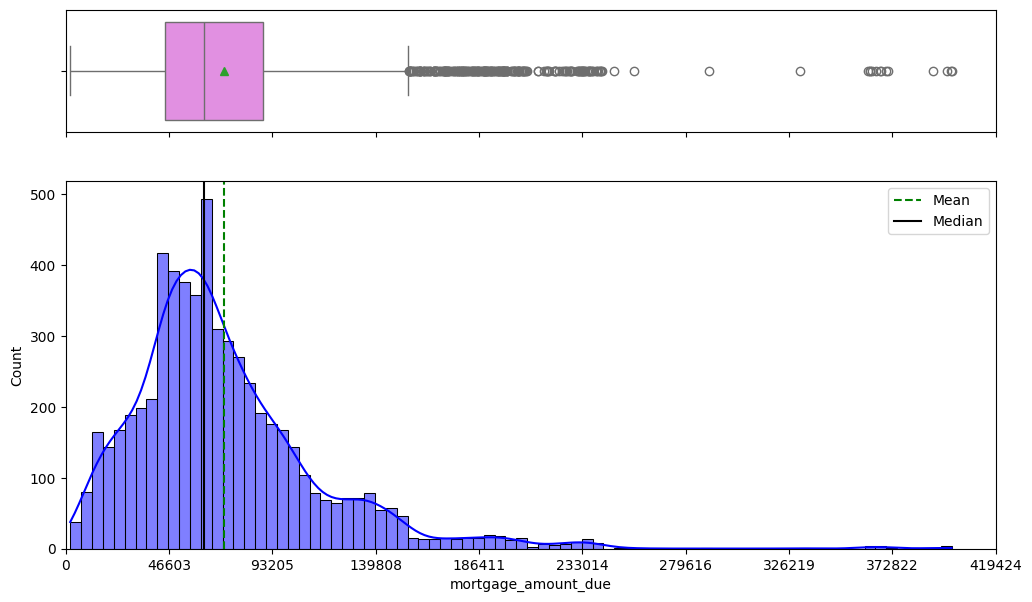

In [89]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[0])

#### Observation:
Mortgage amount due shows a slightly right skewed distribution, but with a lot of outliers. These may need to be treated based on the type of modelling technique used for modeling

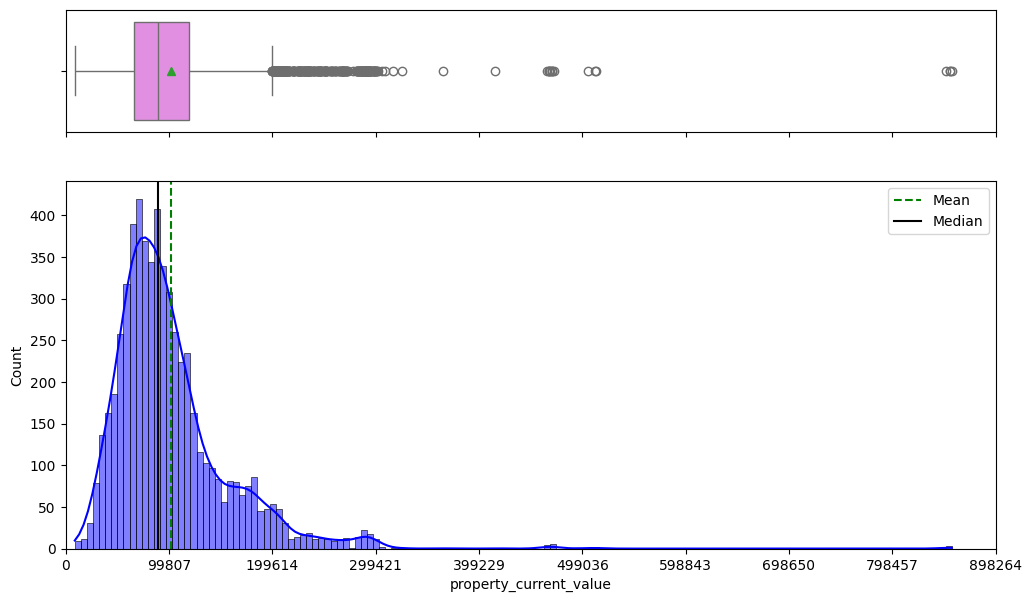

In [90]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[1])

#### Observation:
Current property value shows a slightly right skewed distribution, but with a lot of outliers. These may need to be treated based on the type of modelling technique used for modeling

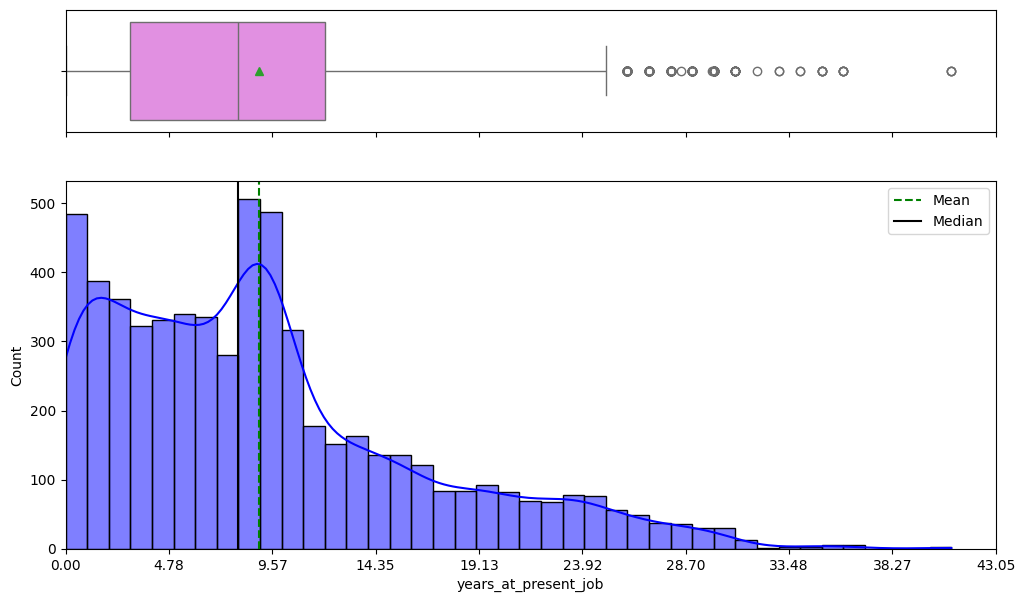

In [91]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[2])

#### Observation:
No of years at present job shows a moderately right skewed, multi-modal distribution, with a few outliers, indicating most loan requesters maybe in middle age group. Extreme outliers may have to be capped

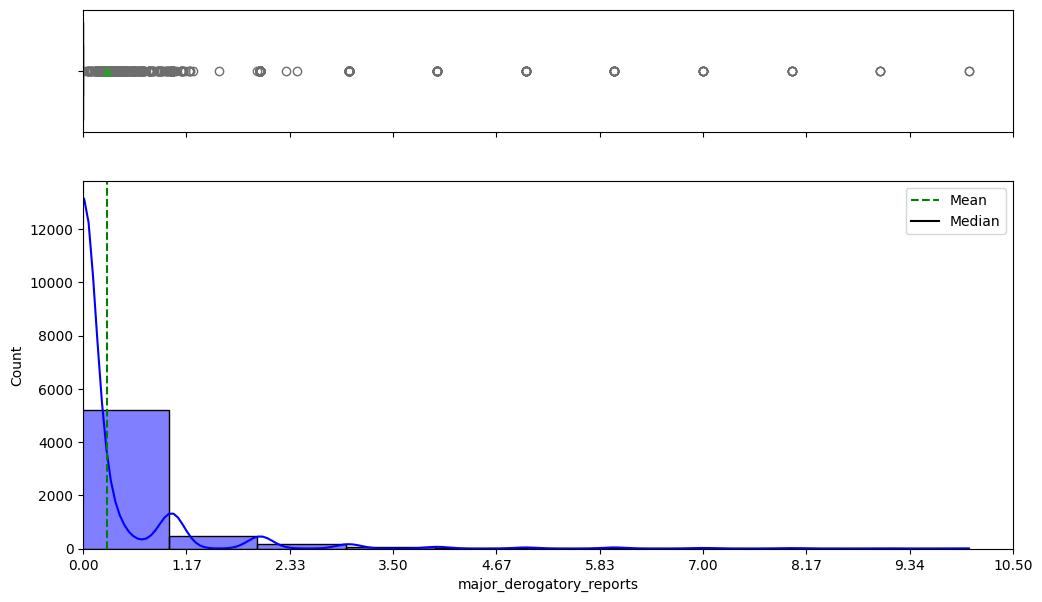

In [92]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[3])

#### Observations:
Major derogatory reports shows a highly right skewed distribution, with most values around zero. This may indicate a bias in the prescreening process

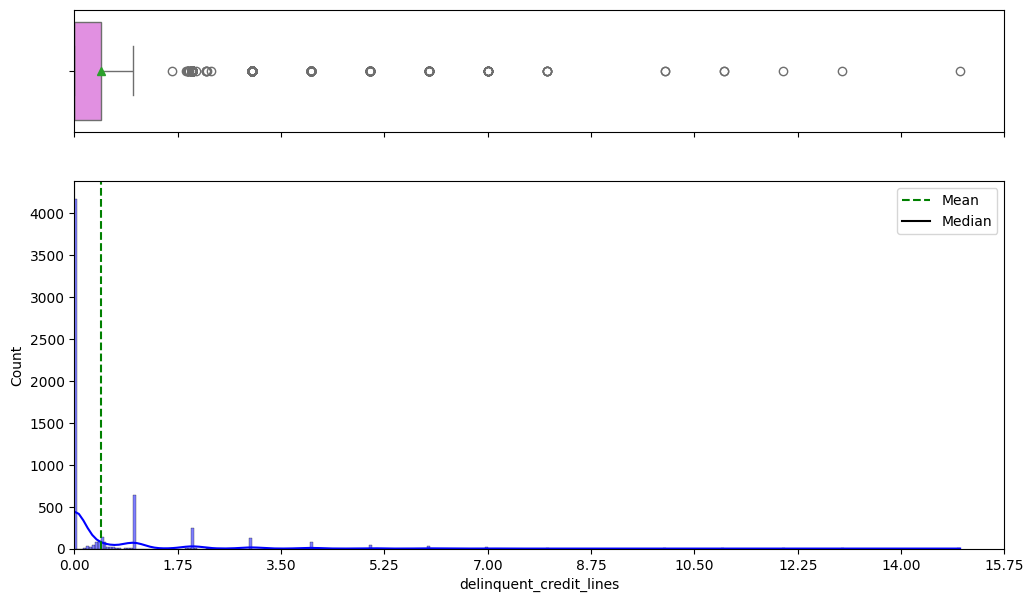

In [93]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[4])

#### Observations:
Delinquent credit lines shows a highly right skewed distribution, with most values around zero. This may indicate a bias in the prescreening process

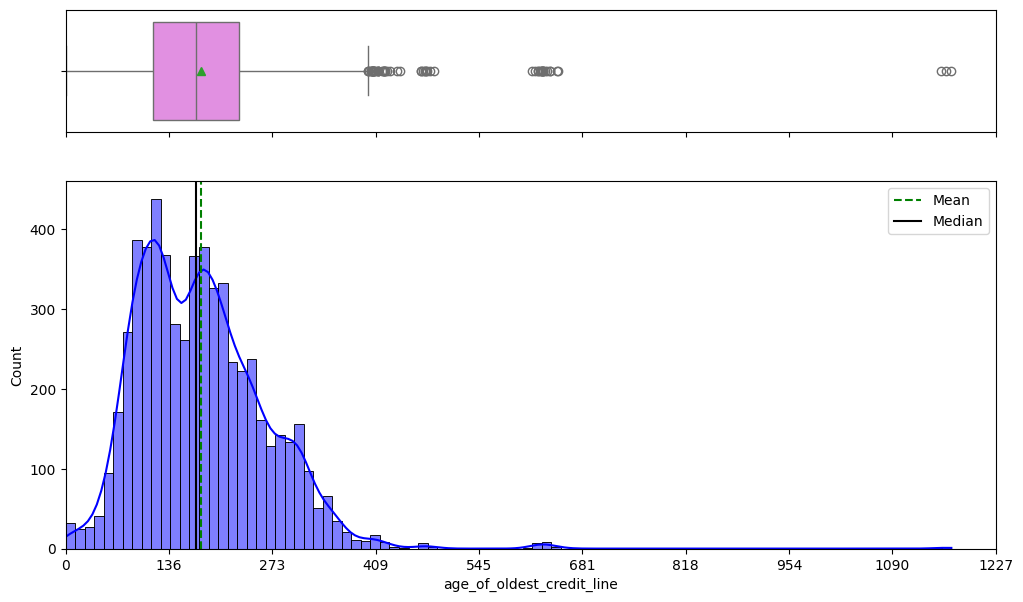

In [94]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[5])

#### Observation:
Oldest credit line shows fairly uniform bi-modal distribution, with quite a few outliers. What maybe of interest here are the loan requesters with low or zero age of credit line. Also extreme outliers may have to be capped

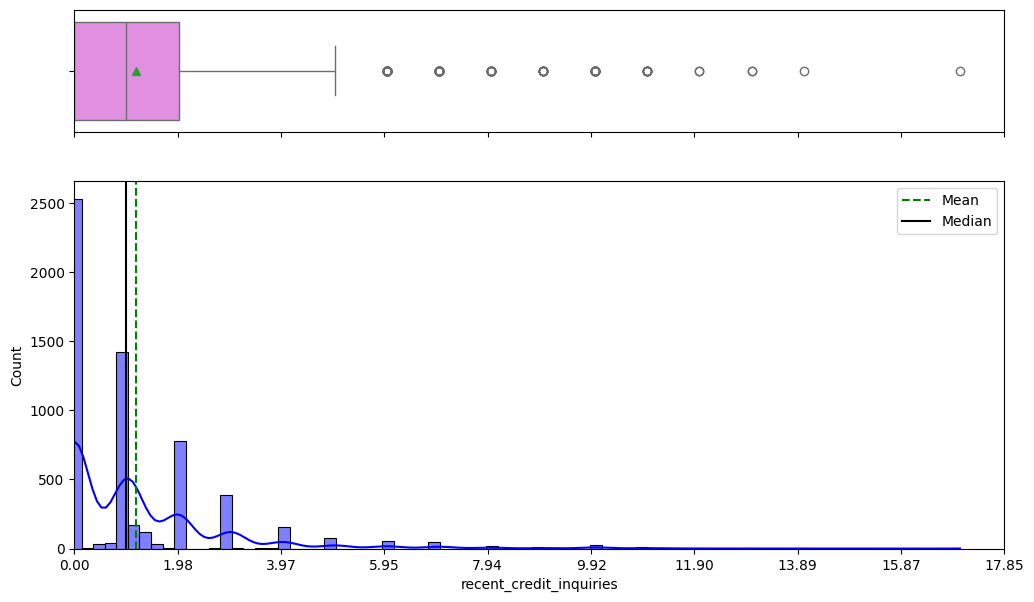

In [95]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[6])

#### Observations:
Recent credit inquiries shows a highly right skewed distribution, with most values around zero. This may indicate a bias in the prescreening process

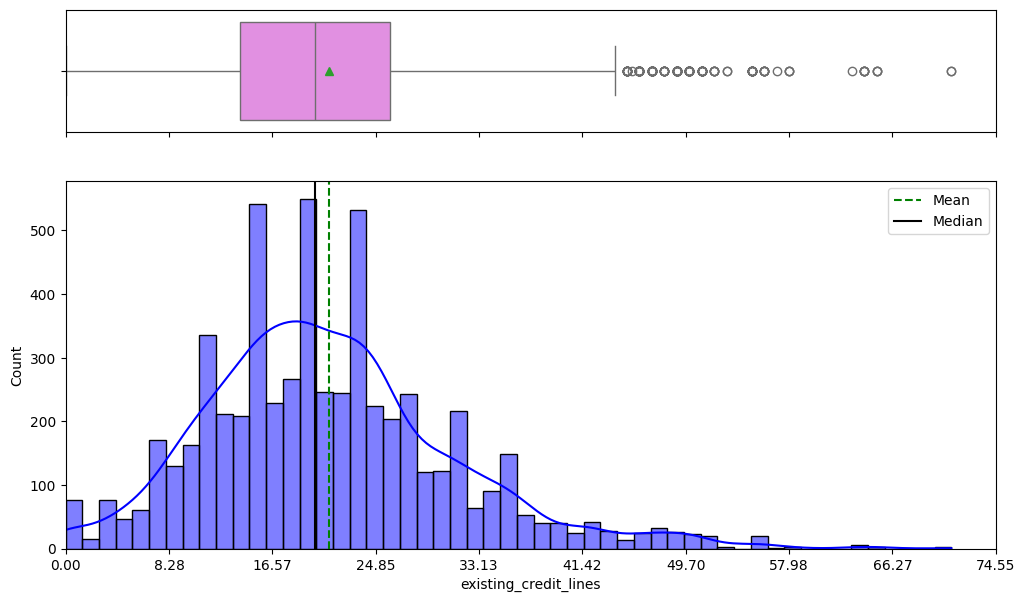

In [96]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[7])

#### Observations:
Existing credit lines shows a reasonably uniform distribution with slight right tail and a few outliers. Extreme outliers may need to be capped

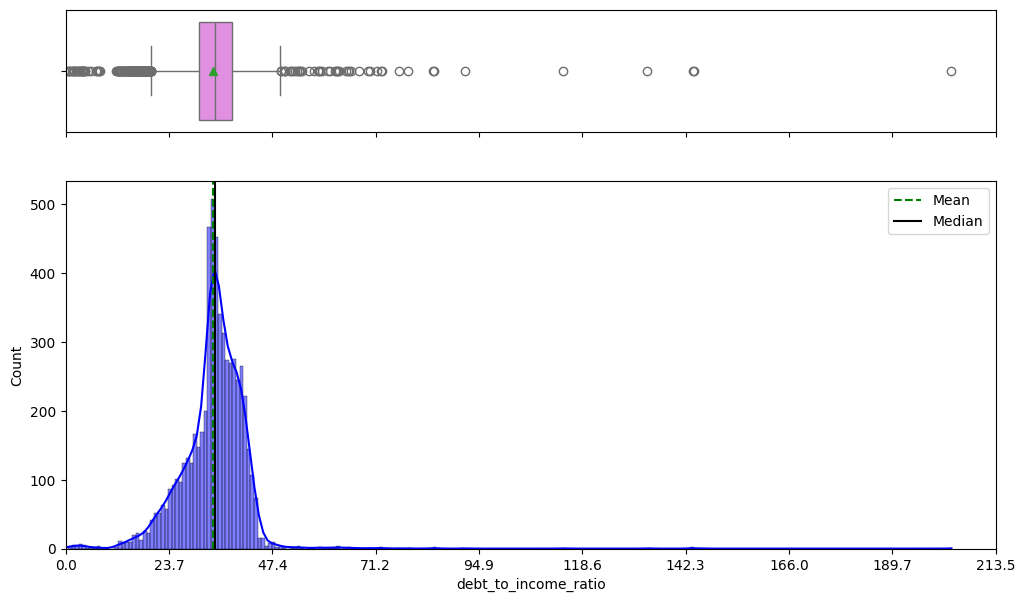

In [97]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[8])

#### Observations:
Debt to income ratio is slightly left skewed, with outliers on both sides. Extreme outlier on the high may need capping. Left skewness is a good thing as a low debt to income ratio is desirable
The distribution is also showing a sharp drop around ~ 40. Should investigate this further

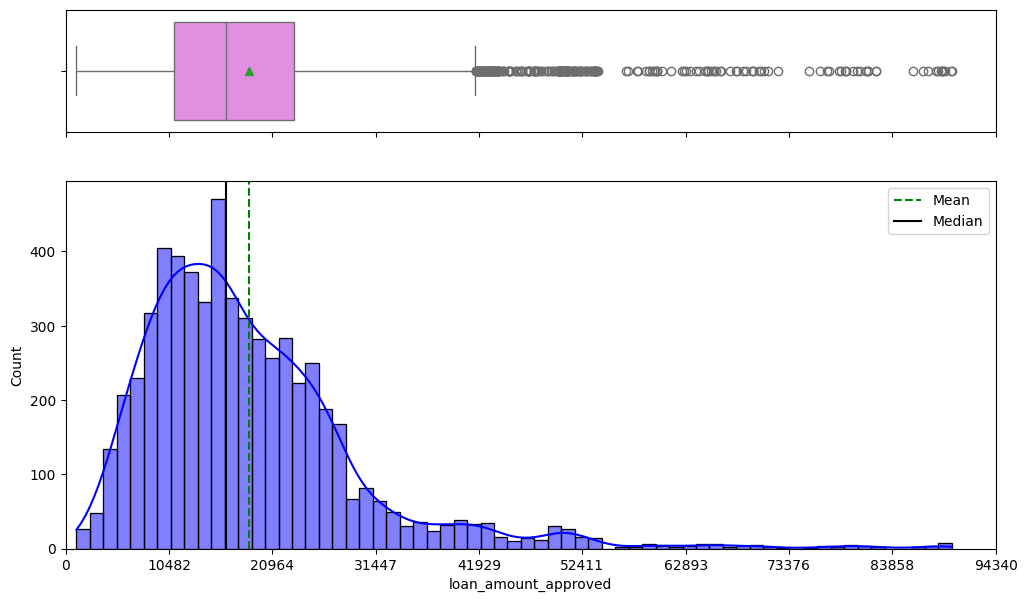

In [98]:
# Plot the numeric variables as histograms and box plots to check skewness and outliers
histogram_boxplot(default_imputed, num_cols[9])

#### Observation:
Amount of loan approved shows a slightly right skewed distribution, but with a lot of outliers. These may need to be treated based on the type of modelling technique used for modeling

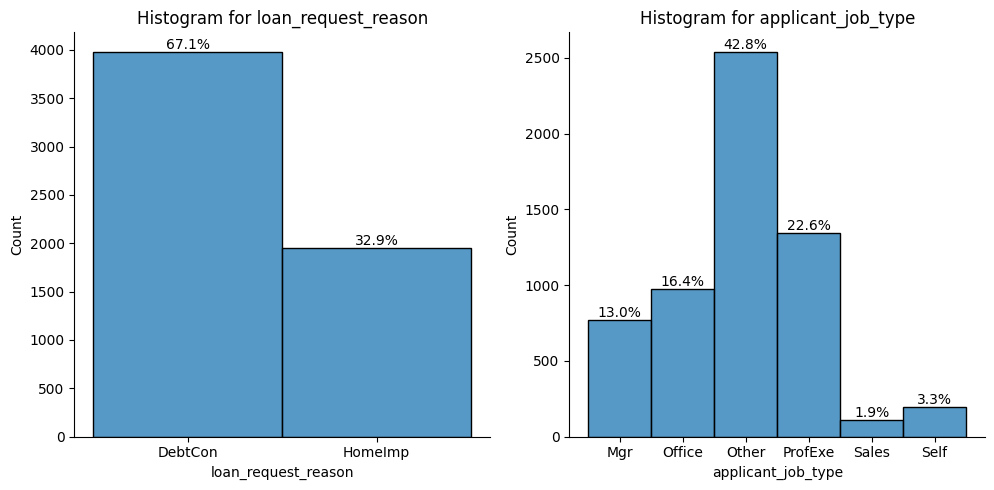

In [99]:
# Plot distribution of categorical columns
# Determine the number of rows and columns for subplots
numof_cols = len(cat_cols)
cols_per_row = 3  # Number of subplots per row
num_rows = math.ceil(numof_cols / cols_per_row)  # Calculate the required number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 5 * num_rows))  # Adjust size as needed
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each column
for i, col in enumerate(cat_cols):
    sns.histplot(default_imputed, x=col, ax=axes[i])  # Use the corresponding subplot axis
    axes[i].set_title(f"Histogram for {col}")
    total = len(default_imputed[col])
    for bar in axes[i].patches:
        height = bar.get_height()
        percentage = (height / total) * 100  # Calculate percentage
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)
    sns.despine()
    
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

#### Observations:
1. ~ 70% of requests are for debt consolidation, indication a fundamental bias in the dataset, or biased selection process
2. Majority (~ 45%) of the loan requests are from people who did not provide details of the profession, suggesting improvements in the data collection process

### **Bivariate Analysis**

### Check correlation for numeric variables

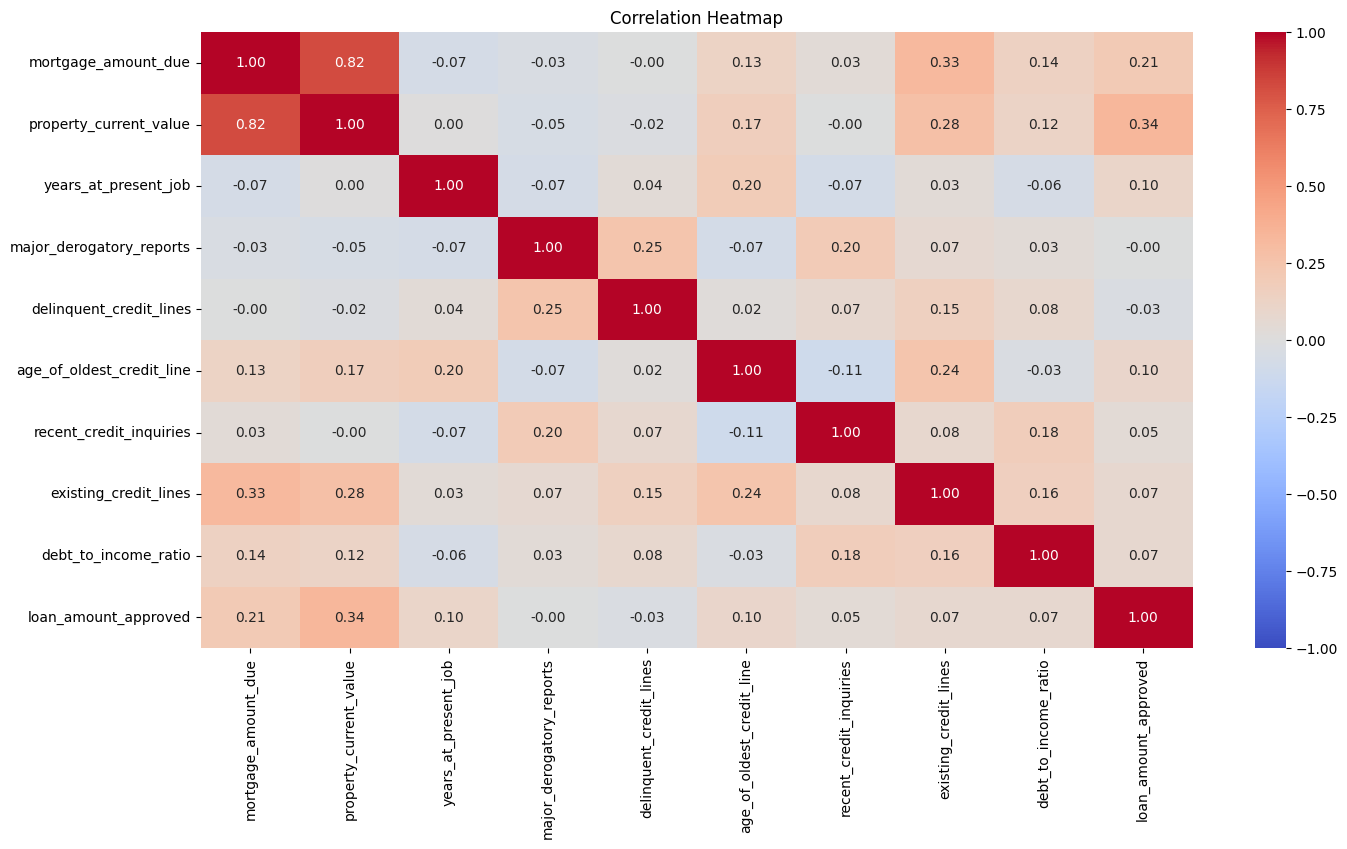

In [100]:
# Calculate the correlation matrix
correlation_matrix = default_imputed[num_cols].corr()
# Plot the heatmap
plt.figure(figsize=(16, 8))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [101]:
# Sort correlations and exclude duplicates
sorted_unique_correlations = (
    correlation_matrix
    .stack()                            # Flatten the matrix into a Series
    .reset_index()                      # Reset index to access column pairs
    .rename(columns={0: 'correlation'})  # Rename correlation column
    .query("level_0 < level_1")         # Keep only one direction (unique pairs)
    .sort_values(by='correlation', ascending=False)  # Sort by correlation
)
# Print the columns with correlation values
print(sorted_unique_correlations)

                      level_0                   level_1  correlation
1         mortgage_amount_due    property_current_value     0.823348
91       loan_amount_approved    property_current_value     0.336835
70      existing_credit_lines       mortgage_amount_due     0.326717
71      existing_credit_lines    property_current_value     0.280797
43    delinquent_credit_lines  major_derogatory_reports     0.245317
57  age_of_oldest_credit_line     existing_credit_lines     0.242950
90       loan_amount_approved       mortgage_amount_due     0.210022
36   major_derogatory_reports   recent_credit_inquiries     0.197341
52  age_of_oldest_credit_line      years_at_present_job     0.195221
86       debt_to_income_ratio   recent_credit_inquiries     0.175763
51  age_of_oldest_credit_line    property_current_value     0.171511
87       debt_to_income_ratio     existing_credit_lines     0.162763
47    delinquent_credit_lines     existing_credit_lines     0.152700
80       debt_to_income_ratio     

#### Observations:
1. Property value as of date seems to have a strong +ve correlation to mortgage amount due. This is only possible if all if the mortgages in the dataset were approved around the same time and the approved mortgage amount was a fixed % of the property value, irrespective of other factors. So age of the mortgage may be a useful feature (latent variable). Most other variables have weak correlations

#### Let's check the distribution of numerical variables to loan defaults

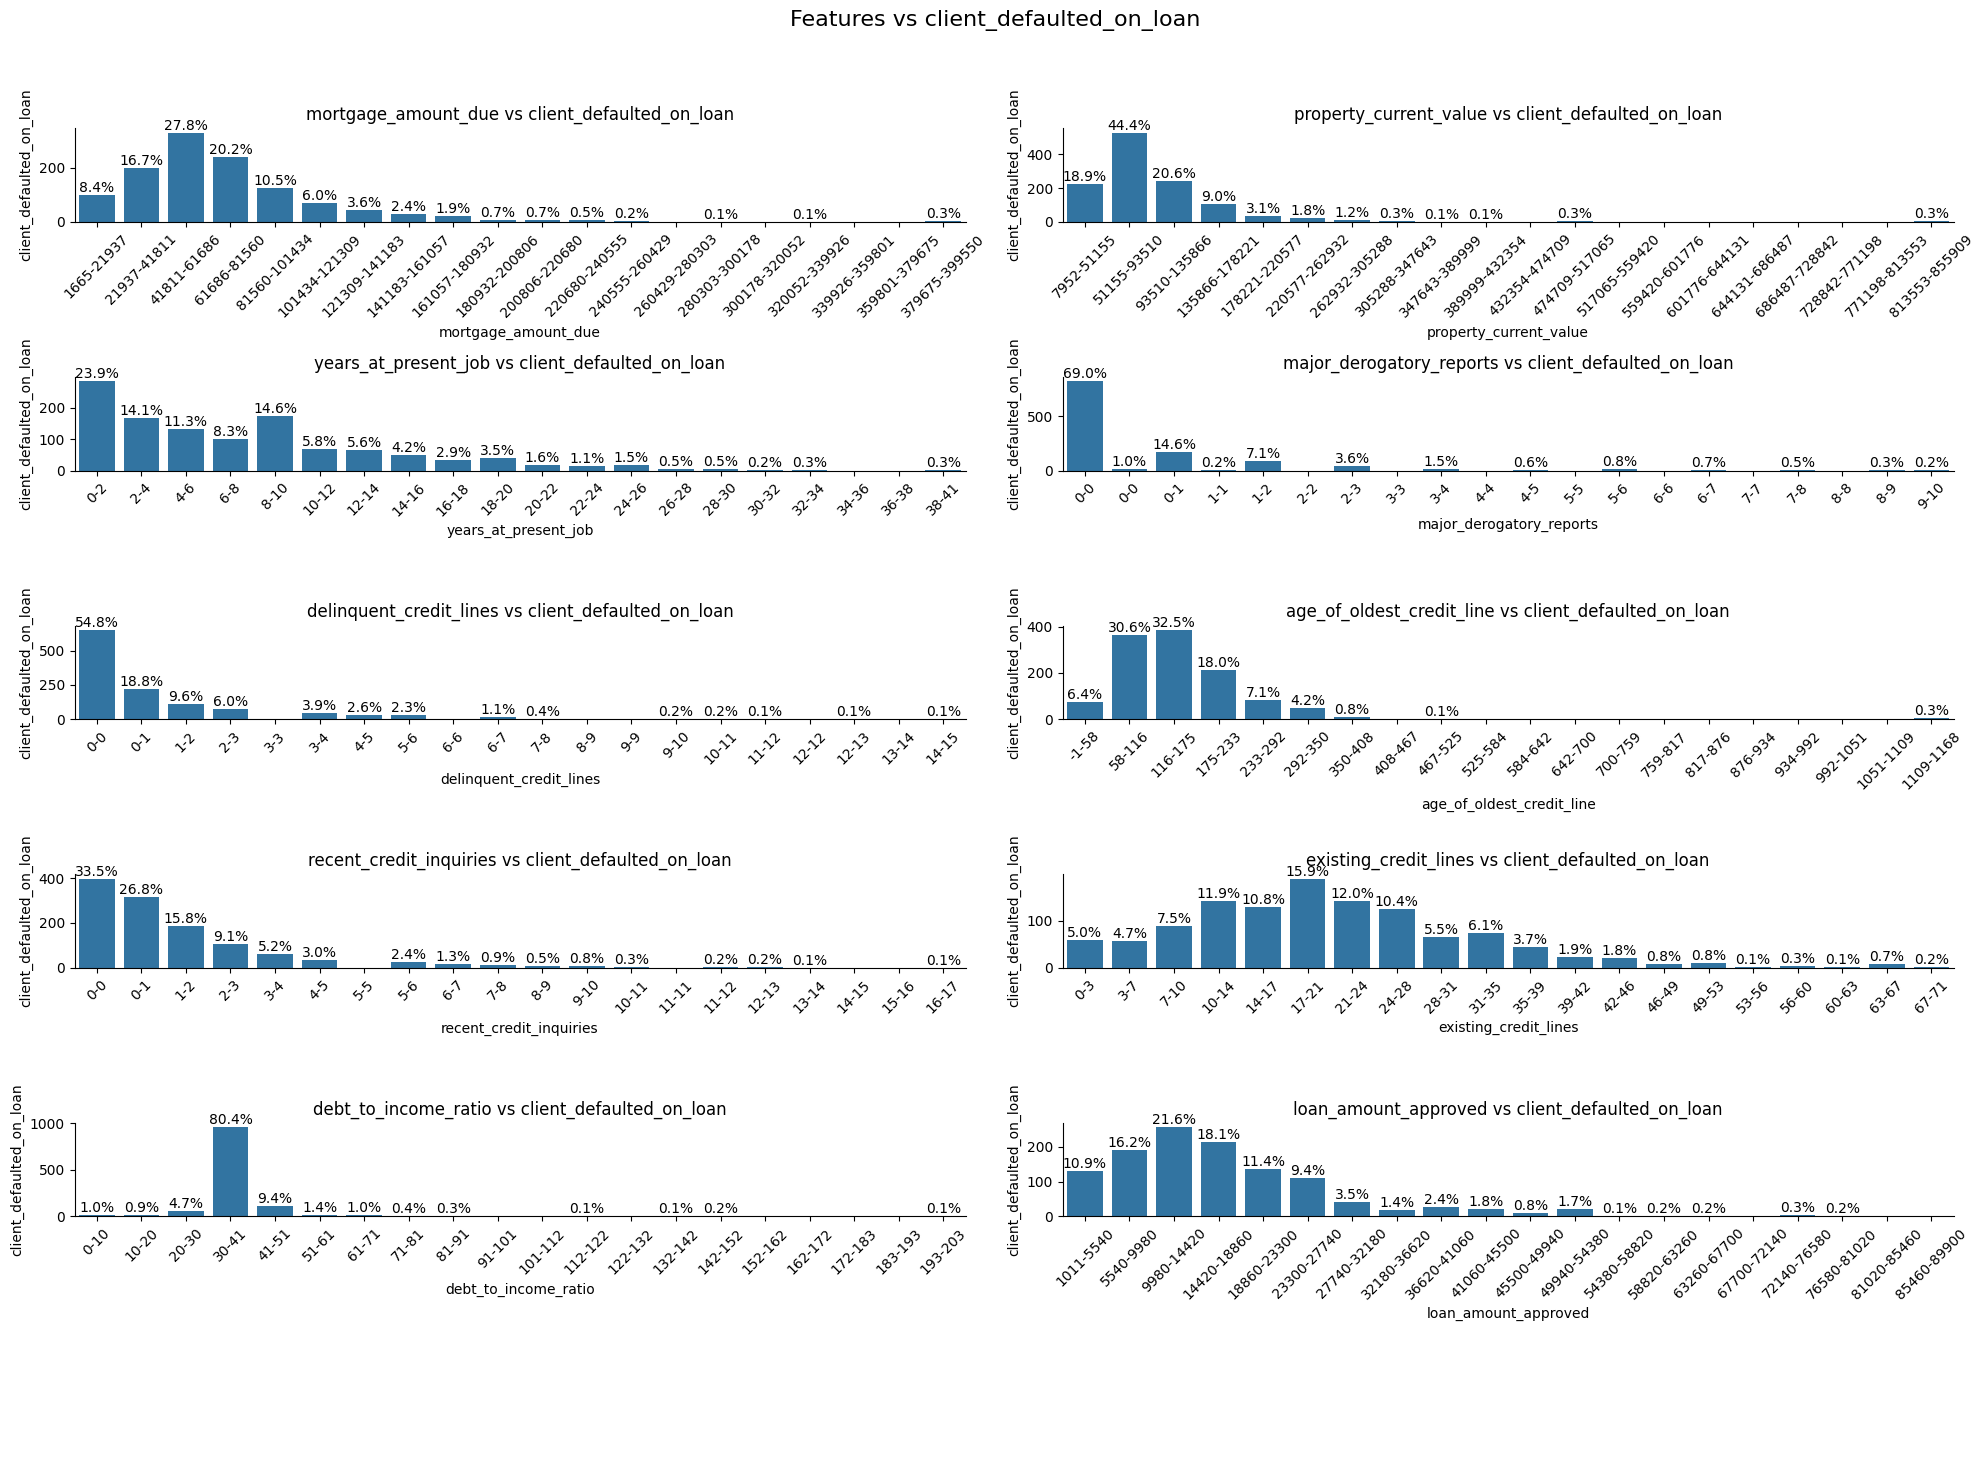

In [102]:
# Function to plot binned features
# Parameters:
# - `default`: DataFrame containing the data
# - `binned_cols_to_plot`: List of columns to be binned and plotted
# - `'client_defaulted_on_loan_num'`: Target variable for analysis (e.g., 1 = defaulted, 0 = not defaulted)
# - `40`: Number of bins to divide the numerical values into for plotting
plot_binned_features(default_imputed, num_cols, 'client_defaulted_on_loan', 20)

#### Observations
1. No of defaulters are highest where recent credit inquiries, delinquent credit lines, major derogatory reports are the lowest. This seems counter intuitive at first, how ever this is most likely due to these customers not having any credit records at all. This will happen if these customers were denied credit in the past and have not applied for credit in the recent time (for the duration during which this data was collected). Additional data is required to understand this anamoly - gross income, demographics, macroeconomic factors such severe recession or other financial distress
2. Default rate is the extra-ordinarily high (80%) for customers with debt to income ratio between 30-41. Understanding this anomaly likely requires a more detailed analysis of the borrower behavior and external conditions. This data set is insufficient for such analysis, as was commented in no 1 above

#### Let's check the distribution of categorical variables to loan defaults

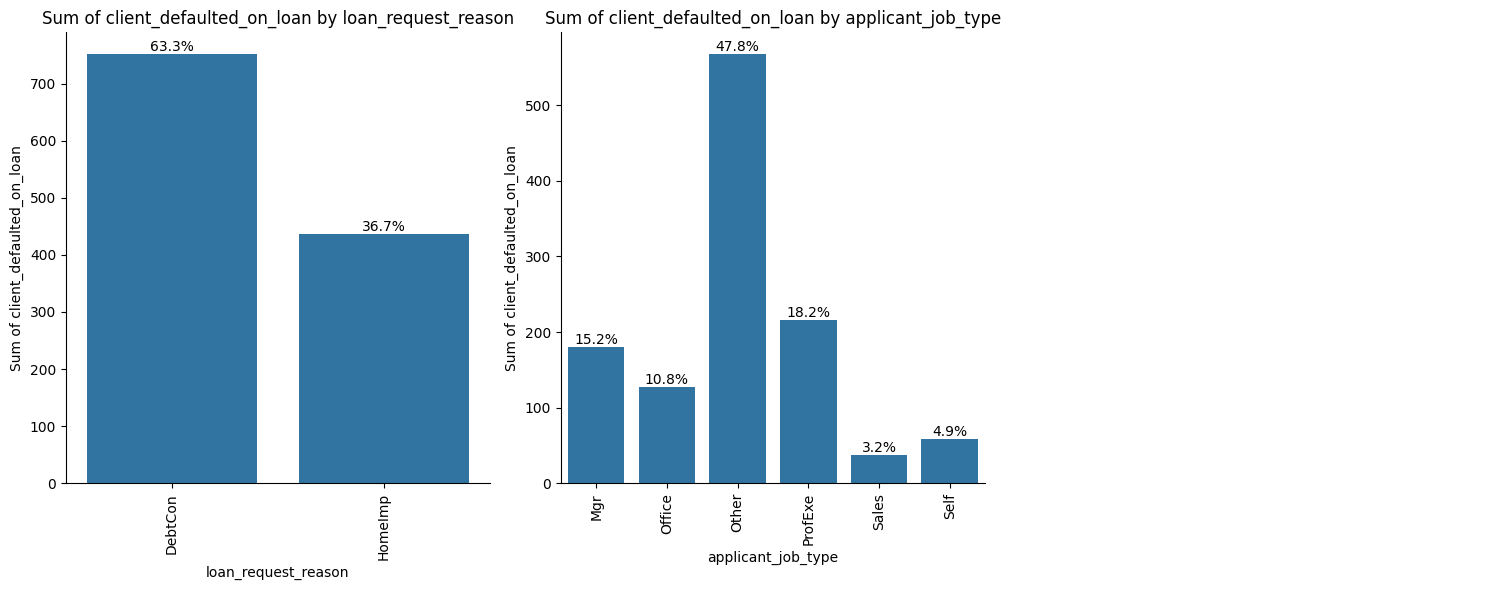

In [103]:
# Plot the categorical variable against the target variable
plot_grouped_barplots(default_imputed, cat_cols, 'client_defaulted_on_loan')

#### Observations:
1. As expected, loan defaults are higher for clients who requested loan for debt consolidation, as these clients already had substantial debt and most likely not enough income to cover the debt
2. Applicants with job type as 'other' have the highest default rate. This may be because these clients do not have a steady job and as such chose not to disclose it. Also the higher default rate for 'Mgr' and 'ProfExe' is interesting and may need further analysis

In [104]:
# Perform the Chi-squared test to see if any of the features are not significant to predicting the target variable
print(chi_squared_test(default_imputed, 'client_defaulted_on_loan'))

                      Feature       P-value  Significant
7     delinquent_credit_lines  3.439216e-76         True
6    major_derogatory_reports  1.917414e-75         True
9     recent_credit_inquiries  7.839235e-32         True
8   age_of_oldest_credit_line  2.204684e-25         True
10      existing_credit_lines  1.385256e-16         True
4          applicant_job_type  5.472220e-16         True
11       debt_to_income_ratio  4.062670e-10         True
0        loan_amount_approved  3.628140e-09         True
2      property_current_value  2.116232e-06         True
5        years_at_present_job  6.555740e-05         True
1         mortgage_amount_due  1.484795e-03         True
3         loan_request_reason  1.991636e-03         True


#### Observation:
1. All the available features are significant for the prediction of target variable
2. Also, features related to clients credit posture seem to have higher significance, which is expected

In [105]:
# Calculate correlation matrix and VIF, excluding the target variable
corr_matrix, vif_values = calculate_corr_and_vif(default_imputed, 'client_defaulted_on_loan')

# Display results
print("Correlation Matrix:")

sorted_corr_matrix = corr_matrix[corr_matrix.columns[corr_matrix.iloc[0].argsort()[::-1]]]

sorted_corr_matrix

Correlation Matrix:


,loan_amount_approved,property_current_value,mortgage_amount_due,years_at_present_job,age_of_oldest_credit_line,existing_credit_lines,debt_to_income_ratio,recent_credit_inquiries,major_derogatory_reports,delinquent_credit_lines
loan_amount_approved,1.000000,0.336835,0.210022,0.103576,0.096181,0.073079,0.070653,0.045754,-0.000074,-0.028510
mortgage_amount_due,0.210022,0.823348,1.000000,-0.068543,0.125605,0.326717,0.143347,0.032090,-0.032003,-0.001169
property_current_value,0.336835,1.000000,0.823348,0.001862,0.171511,0.280797,0.120941,-0.001928,-0.049451,-0.020519
years_at_present_job,0.103576,0.001862,-0.068543,1.000000,0.195221,0.034446,-0.060690,-0.073143,-0.070228,0.038782
major_derogatory_reports,-0.000074,-0.049451,-0.032003,-0.070228,-0.071447,0.069656,0.034229,0.197341,1.000000,0.245317
delinquent_credit_lines,-0.028510,-0.020519,-0.001169,0.038782,0.019350,0.152700,0.083540,0.074652,0.245317,1.000000
age_of_oldest_credit_line,0.096181,0.171511,0.125605,0.195221,1.000000,0.242950,-0.028679,-0.106623,-0.071447,0.019350
recent_credit_inquiries,0.045754,-0.001928,0.032090,-0.073143,-0.106623,0.082074,0.175763,1.000000,0.197341,0.074652
existing_credit_lines,0.073079,0.280797,0.326717,0.034446,0.242950,1.000000,0.162763,0.082074,0.069656,0.152700
debt_to_income_ratio,0.070653,0.120941,0.143347,-0.060690,-0.028679,0.162763,1.000000,0.175763,0.034229,0.083540


In [106]:
# Print VIF values
print(vif_values)

                     Feature        VIF
0       loan_amount_approved   4.269935
1        mortgage_amount_due  12.577660
2     property_current_value  14.438231
3       years_at_present_job   2.609784
4   major_derogatory_reports   1.234639
5    delinquent_credit_lines   1.288038
6  age_of_oldest_credit_line   5.570849
7    recent_credit_inquiries   1.647082
8      existing_credit_lines   6.657924
9       debt_to_income_ratio   9.089406


#### Observation:
current property value shows a very high correlation with mortgage amount due, which is expected. These should be replaced with an engineered feature. Additional insights can be gained from priniciple component analysis

### **Multivariate Analysis**

#### Multivariate analysis using PCA

#### Prep the data for PCA

In [107]:
# Standardize the data using the dataset with all numeric values from the impute missing values function output (PCA works only with numeric values)
default_imputed_scaled = default_imputed_num.drop('client_defaulted_on_loan', axis=1) # Drop the target variable
 # Scale the data using Z transformation
scaler = StandardScaler()
default_imputed_scaled = pd.DataFrame(scaler.fit_transform(default_imputed_scaled), columns=default_imputed_scaled.columns)

In [108]:
# Apply PCA
pca = PCA(n_components=10)  # Reduce to 10 principal components
default_pca = pd.DataFrame(pca.fit_transform(default_imputed_scaled), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

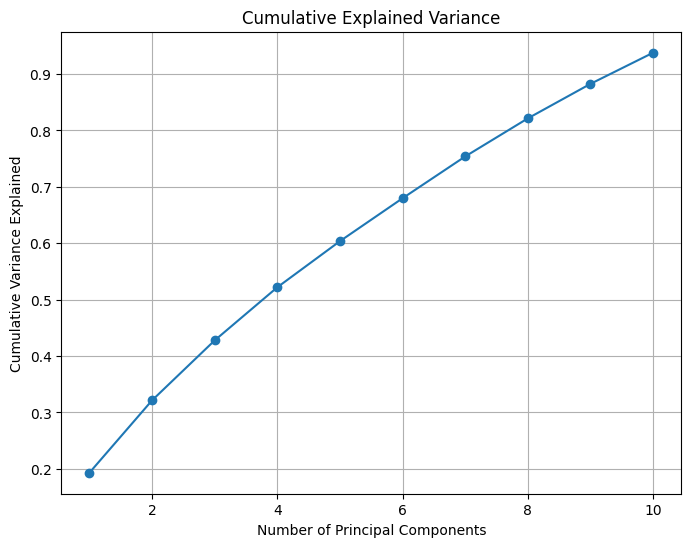

PC1: 19.31%
PC2: 12.84%
PC3: 10.63%
PC4: 9.42%
PC5: 8.18%
PC6: 7.61%
PC7: 7.41%
PC8: 6.75%
PC9: 6.12%
PC10: 5.52%


In [109]:
# Plot the cumulative variance explained by each principle component for 
plot_pca(pca)
# Print explained variance by each component
for i, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"PC{i}: {ratio:.2%}")

#### Observation
There is no single component which can be attributed with a large variance in the dataset

Let's check the contribution of each of the original features to the principle components

In [110]:
# Create a DataFrame to represent the principal component loadings
# Rows are the principal components (PCs), and columns are the original features
loadings = pd.DataFrame(
    pca.components_,  # PCA component weights
    columns=default_imputed_scaled.columns,  # Original feature names
    index=[f'PC{i+1}' for i in range(len(pca.components_))]  # Label PCs as PC1, PC2, etc.
)

# Sort the loadings of the first principal component (PC1) in descending order
# loadings.iloc[0] refers to the first row (PC1), and argsort()[::-1] sorts indices in descending order
sorted_loadings = loadings[loadings.columns[loadings.iloc[0].argsort()[::-1]]]

# Display the sorted loadings
sorted_loadings

,property_current_value,mortgage_amount_due,existing_credit_lines,loan_amount_approved,age_of_oldest_credit_line,debt_to_income_ratio,applicant_job_type,recent_credit_inquiries,delinquent_credit_lines,years_at_present_job,major_derogatory_reports,loan_request_reason
PC1,0.576112,0.564984,0.365788,0.305518,0.218580,0.178757,0.176315,0.053215,0.036729,0.019602,-0.012193,-0.078832
PC2,-0.093113,-0.024116,0.157196,-0.032304,-0.278719,0.338654,-0.160091,0.511072,0.366841,-0.251812,0.483022,-0.233470
PC3,-0.132263,-0.162364,0.305187,-0.092110,0.483609,-0.051080,-0.069939,-0.083843,0.493531,0.488090,0.243976,0.254524
PC4,0.098927,0.163554,0.003535,-0.436486,-0.111430,-0.049082,0.415361,-0.139306,0.157561,-0.417550,0.192387,0.574446
PC5,-0.032727,0.052813,0.257030,-0.460685,0.129790,0.534424,-0.433102,-0.043678,-0.109916,-0.109107,-0.435882,0.109201
PC6,0.085399,-0.026710,-0.384590,0.295329,-0.176204,0.454081,0.004328,0.250325,-0.077816,0.360811,-0.002498,0.566304
PC7,-0.284060,-0.262775,0.221210,-0.032446,0.225009,0.265317,0.701409,0.301882,-0.225197,0.027548,-0.164132,-0.133160
PC8,0.069075,0.083879,0.067089,-0.188289,0.285217,-0.379258,-0.232844,0.568766,-0.502117,-0.001529,0.218310,0.213448
PC9,0.106624,0.194785,0.085709,-0.407826,-0.477220,-0.239403,0.141333,0.275006,0.183974,0.505097,-0.307595,-0.113060
PC10,-0.002660,0.036289,0.216231,-0.190367,-0.256801,0.218407,0.039390,-0.392728,-0.484286,0.336688,0.534570,-0.112197


#### Create a new feature to replace Mortgage due and property value as they are highly correlated, and check if it impacts the PCs

In [111]:
# Create a df for engineered features
default_imputed_scaled_eng = default_imputed_scaled.copy()

# New feature is the ratio of mortgate due to property value
default_imputed_scaled_eng['mortgage_to_property_ratio'] = default_imputed_scaled_eng['mortgage_amount_due'] / default_imputed_scaled_eng['property_current_value']

# Drop the original features
default_imputed_scaled_eng.drop(['mortgage_amount_due', 'property_current_value'], axis=1, inplace=True)

# Scale the new feature
default_imputed_scaled_eng['mortgage_to_property_ratio'] = StandardScaler().fit_transform(
    default_imputed_scaled_eng[['mortgage_to_property_ratio']]
)

In [112]:
# Apply PCA
pca_nopv = PCA(n_components=10)  # First 10 PCs
default_pcanopv = pd.DataFrame(pca_nopv.fit_transform(default_imputed_scaled_eng), columns=['PCe1', 'PCe2', 'PCe3', 'PCe4', 'PCe5', 'PCe6', 'PCe7', 'PCe8', 'PCe9', 'PCe10'])

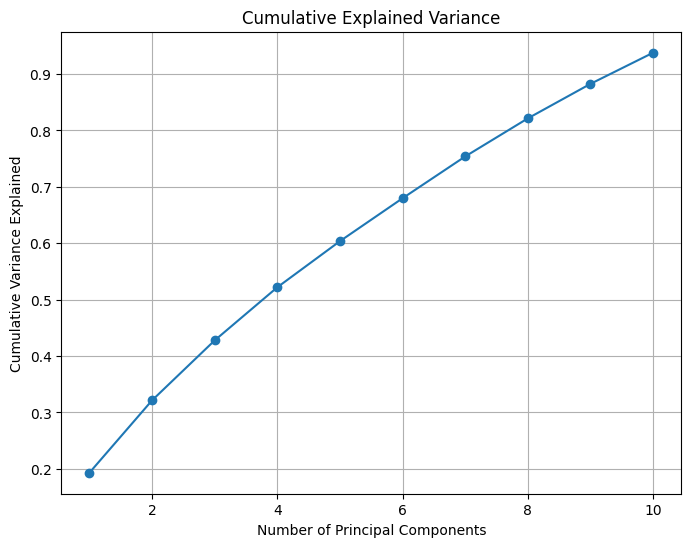

PCe1: 14.21%
PCe2: 13.05%
PCe3: 10.93%
PCe4: 9.61%
PCe5: 9.17%
PCe6: 8.88%
PCe7: 8.19%
PCe8: 7.42%
PCe9: 6.88%
PCe10: 6.02%


In [113]:
# Plot explained variance ratio
plot_pca(pca_nopv)

# Print explained variance by each component
for i, ratio in enumerate(pca_nopv.explained_variance_ratio_, start=1):
    print(f"PCe{i}: {ratio:.2%}")

In [114]:
loadings_noPV = pd.DataFrame(pca_nopv.components_, columns=default_imputed_scaled_eng.columns, index=[f'PCe{i+1}' for i in range(len(pca_nopv.components_))])
sorted_loadings_noPV = loadings_noPV[loadings_noPV.columns[loadings_noPV.iloc[0].argsort()[::-1]]]
sorted_loadings_noPV

,recent_credit_inquiries,major_derogatory_reports,debt_to_income_ratio,delinquent_credit_lines,existing_credit_lines,loan_amount_approved,mortgage_to_property_ratio,age_of_oldest_credit_line,applicant_job_type,years_at_present_job,loan_request_reason
PCe1,0.483021,0.437931,0.403157,0.396194,0.381547,0.154054,-0.002213,-0.041971,-0.051839,-0.119536,-0.259518
PCe2,-0.185975,-0.158836,0.027133,0.068006,0.440729,0.328600,-0.054357,0.625871,0.208210,0.440109,0.029765
PCe3,-0.141348,0.359382,-0.163761,0.500103,0.038205,-0.472916,0.081498,0.128777,-0.031688,0.121913,0.556546
PCe4,-0.034753,-0.031385,0.145670,-0.128218,0.193107,-0.084681,0.116205,-0.007708,0.774984,-0.501743,0.223106
PCe5,-0.093918,-0.125821,0.005852,-0.002576,0.160512,-0.129036,0.931971,0.025127,-0.137553,0.009290,-0.211389
PCe6,-0.003477,-0.423846,0.594608,-0.128046,0.222273,-0.418444,-0.169025,0.124122,-0.359620,-0.121863,0.194257
PCe7,0.263959,-0.010993,0.430953,-0.088308,-0.351397,0.309891,0.255045,-0.177457,0.121063,0.408692,0.488824
PCe8,0.656068,0.134641,-0.317828,-0.503714,0.114697,-0.272325,0.039374,0.295856,-0.016963,0.096905,0.103097
PCe9,0.202133,-0.348997,-0.035993,0.243467,0.059042,-0.418077,-0.100395,-0.337446,0.391011,0.480007,-0.302079
PCe10,-0.401370,0.545022,0.252952,-0.477929,0.179816,-0.207754,-0.051600,-0.202716,0.066854,0.320879,-0.150890


#### Observations
Based on PCA analysis, it is clear that replacing 'mortgage_amount_due', 'property_current_value' by 'mortgage_to_property_ratio' will not impact modelling performance

## Treating Outliers
Only the outliers for mortgage due and property value have been dropped, where the ratio of these features was improbable. See section to 1.4.0.1. All the other outliers are maintained as is as they seem to be realistic data points

## Treating Missing Values: See section 1.6.1.1

## **Important Insights from EDA**

### Key Data Insights for Classification

#### Handling Missing Values
- Critical features like `loan_request_reason` and `property_current_value` must have no missing values as they are essential for predicting loan defaults.
- Features like `major_derogatory_reports` and `debt_to_income_ratio` (with missing rates of 11.9% and 21.3%) require imputation or exclusion based on their impact.

#### Dataset Characteristics
- **Records**: 5960 with no duplicates.
- **Default Rate**: High (20%), indicating no class imbalance but potential dataset biases.
- **Target Variable**: Well-defined (`loan_default`).

#### Potential Predictors
- Features such as `debt_to_income_ratio`, `major_derogatory_reports`, `recent_credit_inquiries`, and `existing_credit_lines` are likely predictive but require normalization and outlier treatment.

#### Feature Engineering
- Replace correlated variables (`mortgage_amount_due` and `property_current_value`) with `mortgage_to_property_ratio`.
- Consider creating latent features such as "age of mortgage" or "credit history duration" for added predictive power.

#### Skewness and Outliers
- Many numerical features (e.g., `debt_to_income_ratio`, `mortgage_amount_due`) are right-skewed with significant outliers.
- Apply transformations and outlier capping to improve model robustness.

#### Bias and Feature Validity
- Categorical variables like `applicant_job_type` and `loan_request_reason` show inherent bias (e.g., 70% of loans are for debt consolidation).
- Features like `job_type` and `years_at_present_job` may raise ethical or legal concerns.

#### Class Separation and Patterns
- Default rates are high for clients with minimal credit records or specific debt-to-income ranges (30–41%).
- This highlights actionable risk segments.

---

### Key Statistical Insights

#### Correlations
- Strong correlation between `property_current_value` and `mortgage_amount_due` supports dimensionality reduction.
- Weak correlations across most features suggest the need for engineered features or interaction terms.

#### Categorical Variable Impact
- High default rates for specific `job_type` categories (`other`, `Mgr`, `ProfExe`) suggest profession-based insights could improve classification if handled carefully.

---

### Recommendations for Modeling

#### Preprocessing
- Treat missing values based on correlation and domain importance.
- Normalize or transform skewed features and cap outliers.
- Create engineered features (e.g., `mortgage_to_property_ratio`).

#### Bias Mitigation
- Address potential dataset bias (e.g., over-representation of debt consolidation loans).
- Carefully handle legally sensitive features like `job_type` to avoid bias in classification.

#### Feature Selection
- Prioritize credit-related features (`debt_to_income_ratio`, `recent_credit_inquiries`, `delinquent_credit_lines`) given their significance for predicting defaults.

#### Advanced Analysis
- Investigate latent variables and external data (e.g., economic conditions) to explain observed anomalies in defaults.

## **Model Building - Approach**
- Data preparation
- Partition the data into train and test set
- Build the model
- Fit on the train data
- Tune the model
- Test the model on test set

In [115]:
# Create a dataframe for modeling from original imputed dataframe
default_model = copy.deepcopy(default_imputed)
default_model['ltv'] = default_model['mortgage_amount_due']/default_model['property_current_value']  # Create the new ltv feature

In [116]:
default_model.drop(columns=['mortgage_amount_due', 'property_current_value'], inplace=True)  # Drop the original feature used to create ltv

In [117]:
# Transform the categorical variables using one-hot encoding
default_model = pd.get_dummies(default_model, columns=['loan_request_reason', 'applicant_job_type'])

In [118]:
# Separate the target variable
Y = default_model.client_defaulted_on_loan
X = default_model.drop('client_defaulted_on_loan', axis=1)

In [119]:
Y.value_counts()

client_defaulted_on_loan
0    4747
1    1188
Name: count, dtype: int64

In [120]:
# Scale the data
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [121]:
# Create the training anb testing datasets
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 1, stratify = Y)
# Reset index of test set for alignment
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Confusion Matrix

<div style="display: inline-block">
    
| Actual/Predicted       | Predicted: 0 (No Default) | Predicted: 1 (Default)|
|:-----------------------|:--------------------------|:----------------------|
| Actual: 0 (No Default) | True Negative (TN)        | False Positive (FP)   |
| Actual: 1 (Default)    | False Negative (FN)       | True Positive (TP)    |

</div>

Classification model should maximize the expected value of the revenue from lending. In order to acheive this:
1. Maximize True Negatives - This will bring in the bulk of the interest revenue
2. Minimize False Negatives - This will reduce the interest loss due to defaulted loans (principle can be recouped via foreclosure)
3. Minimize False Positives - This will minimize the opportunity loss
To achieve this, we will define 2 functions
### Function to calculate the expected revenue:

$
\text{Expected Revenue} = \text{Revenue from True Negatives (TN)} - \text{Loss from False Positives (FP)} - \text{Loss from False Negatives (FN)}
$

1. Revenue from True Negatives (TN):

$
\text{Revenue}{\text{TN}} = P{\text{ND}} \cdot (1 - \text{Actual}) \cdot L \cdot r
$
Where:
	•	$P_{\text{ND}} = 1 - P_{\text{D}}$: Probability of non-default.
	•	$\text{Actual}$: Indicator of the actual outcome ($0$ = non-default, $1$ = default).
	•	$L$: Loan amount.
	•	$r$: Interest rate.

2. Loss from False Positives (FP):

$
\text{Loss}{\text{FP}} = P{\text{D}} \cdot (1 - \text{Actual}) \cdot L \cdot r
$
Where:
	•	$P_{\text{D}}$: Probability of default.
	•	$(1 - \text{Actual})$: Ensures the outcome is non-default ($\text{Actual} = 0$).
	•	$L \cdot r$: Opportunity cost (lost interest revenue).

3. Loss from False Negatives (FN):

$
\text{Loss}{\text{FN}} = P{\text{ND}} \cdot \text{Actual} \cdot L \cdot (1 + r)
$
Where:
	•	$P_{\text{ND}}$: Probability of non-default.
	•	$\text{Actual}$: Ensures the outcome is default ($\text{Actual} = 1$).
	•	$L \cdot (1 + r)$: Total loss (principal + interest).

Final Formula:

$
\text{Expected Revenue} = \left( P_{\text{ND}} \cdot (1 - \text{Actual}) \cdot L \cdot r \right)
	•	\left( P_{\text{D}} \cdot (1 - \text{Actual}) \cdot L \cdot r \right)
	•	\left( P_{\text{ND}} \cdot \text{Actual} \cdot L \cdot (1 + r) \right)
$

Definitions:
	•	$P_{\text{D}}$: Probability of default.
	•	$P_{\text{ND}} = 1 - P_{\text{D}}$: Probability of non-default.
	•	$\text{Actual}$: Binary variable ($0 = \text{Non-default}, 1 = \text{Default}$).
	•	$L$: Loan amount.
	•	$r$: Interest rate.

In [122]:
model_metrics = pd.DataFrame(columns = ['Model Name', 'Model Type', 'Grid Search (Yes/No)', 'Recall', 'Precision', 'f1', 'Accuracy', 'FPs', 'FNs', 'Revenue Prediction', 'Confidence'])
model_metrics

,Model Name,Model Type,Grid Search (Yes/No),Recall,Precision,f1,Accuracy,FPs,FNs,Revenue Prediction,Confidence


### Logistic Regression

In [123]:
# Fit logistic regression model to training data with default parameters except solver = liblinear, since liblinear solver is optimized for linear problems with small datasets and binary classification
lg = LogisticRegression(verbose=1, solver='liblinear', random_state=1)
lg.fit(x_train, y_train)

[LibLinear]iter  1 act 1.129e+03 pre 1.027e+03 delta 1.507e+00 f 2.879e+03 |g| 1.543e+03 CG   2
iter  2 act 8.510e+01 pre 7.440e+01 delta 1.507e+00 f 1.750e+03 |g| 3.049e+02 CG   2
iter  3 act 6.884e+00 pre 6.498e+00 delta 1.507e+00 f 1.665e+03 |g| 6.961e+01 CG   3
iter  4 act 6.872e-02 pre 6.826e-02 delta 1.507e+00 f 1.658e+03 |g| 6.357e+00 CG   2
iter  5 act 1.542e-04 pre 1.542e-04 delta 1.507e+00 f 1.658e+03 |g| 4.511e-01 CG   3


LogisticRegression(random_state=1, solver='liblinear', verbose=1)

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      3323
           1       0.70      0.29      0.41       831

    accuracy                           0.83      4154
   macro avg       0.77      0.63      0.65      4154
weighted avg       0.82      0.83      0.80      4154



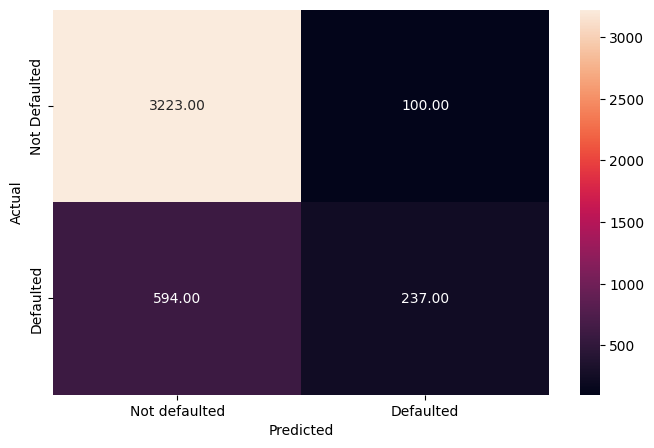

In [124]:
# Check the performance on the training data
y_pred_train = lg.predict(x_train)
metrics_score(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1424
           1       0.75      0.27      0.40       357

    accuracy                           0.84      1781
   macro avg       0.80      0.63      0.65      1781
weighted avg       0.82      0.84      0.80      1781



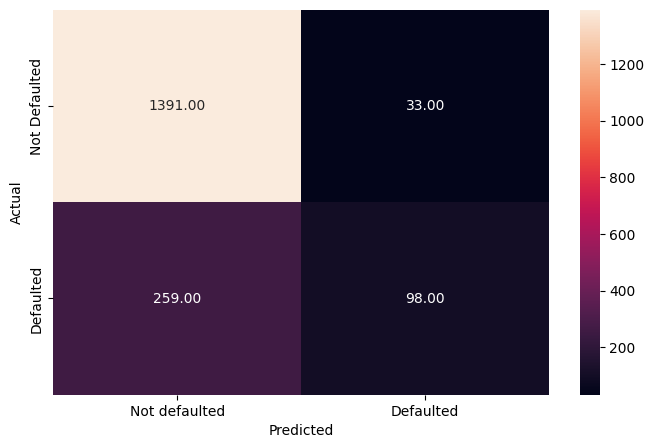

Total expected revenue: 2698670.8381685987 with confidence of: 0.8378248172411434


In [125]:
# Checking the performance on the test data

# Check the metrics on the test data
y_pred_test_lg = lg.predict(x_test)
metrics_score(y_test, y_pred_test_lg)

# get the probabilities and update in the dataset
default_model_lg = default_model.copy()
pred_prob_lg = lg.predict_proba(X_scaled)
default_model_lg['prob_default'] = pred_prob_lg[:, 1]  # Column for P(default)

# Calculate the expected revenue
revenue_lg, confidence_lg = calculate_expected_with_confidence(default_model_lg, 'loan_amount_approved')
print("Total expected revenue:", revenue_lg, 'with confidence of:', confidence_lg)

In [126]:
cr = classification_report(y_test, y_pred_test_lg, output_dict=True)
cm = confusion_matrix(y_test, y_pred_test_lg)
lg_metrics_compare = {'Model Name': 'lg',
                      'Model Type': 'Logistic Regression',
                      'Grid Search (Yes/No)': 'No',
                      'Recall': cr['1']['recall'],
                      'Precision':cr['1']['precision'],
                      'f1': cr['1']['f1-score'],
                      'Accuracy':cr['accuracy'], 
                      'FPs': cm[0][1],
                      'FNs': cm[1][0],
                      'Revenue Prediction': revenue_lg,
                      'Confidence': confidence_lg
                     }
model_metrics.loc[len(model_metrics)] = lg_metrics_compare

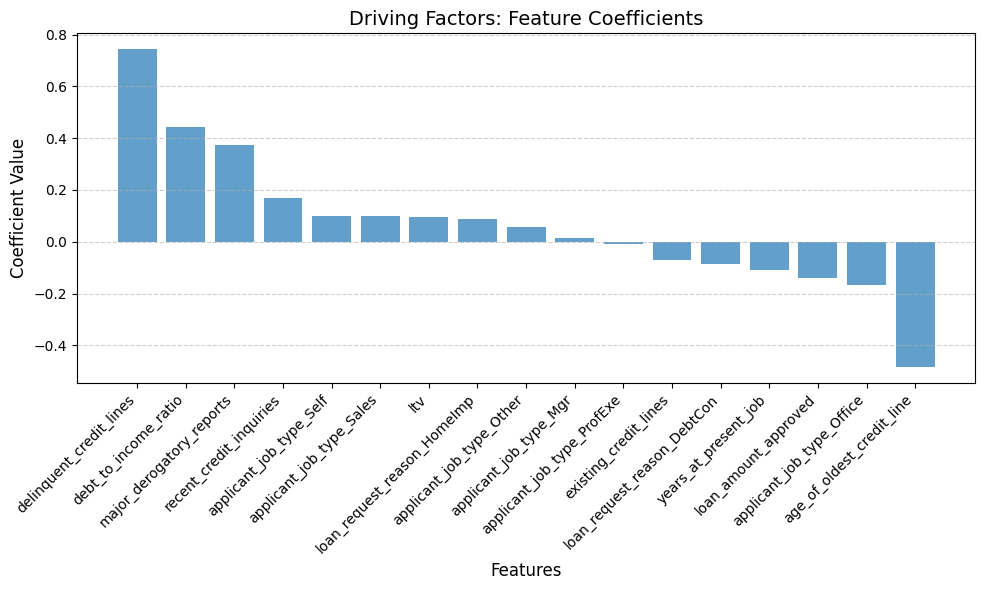

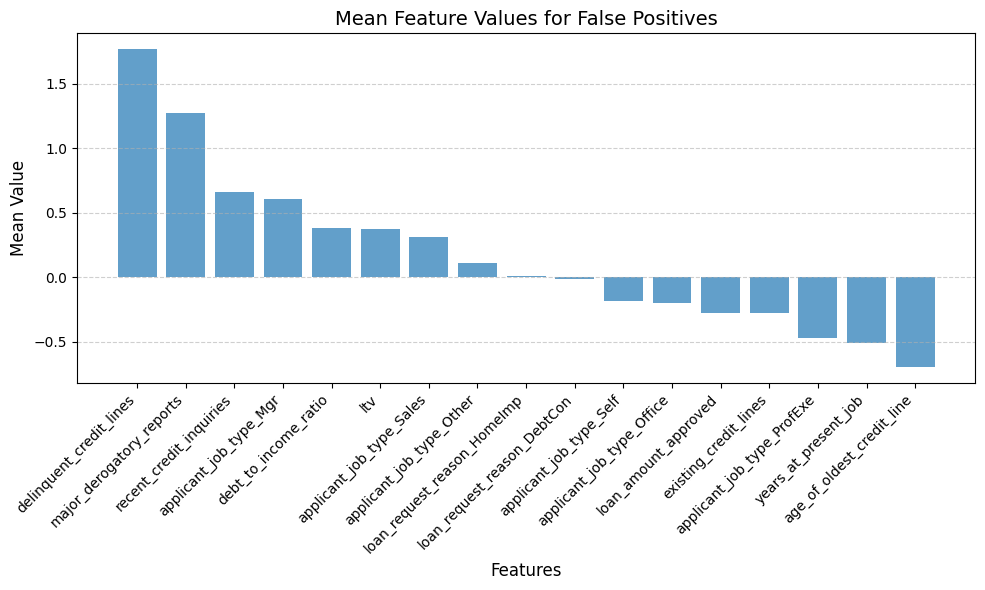

In [127]:
# Driving Factors: Feature Importance
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Plot 1: Feature Coefficients
plt.figure(figsize=(10, 6))
plt.bar(coefficients['Feature'], coefficients['Coefficient'], alpha=0.7)
plt.title('Driving Factors: Feature Coefficients', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Predict probabilities and labels
y_pred_prob = lg.predict_proba(x_test)[:, 1]
y_pred = lg.predict(x_test)

# Compute confusion matrix to identify false positives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Filter false positives (predicted 1, actual 0)
false_positives_df = x_test[(y_pred == 1) & (y_test == 0)]

# Visualize mean feature values
false_positive_features = false_positives_df.mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(false_positive_features.index, false_positive_features.values, alpha=0.7)
plt.title('Mean Feature Values for False Positives', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Mean Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Observation
The performance of the model on the trained data and test data is almost identical.\
Primary driving factors are related to the -ve credit history of the client and the income.\
Loan amount approved and existing credit lines has a negative coefficient.\
Overall the performance of Logistic regression is not satisfactory as the recall is very low.

**Let's see if we can improve the performance by gridsearch**

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Expected profit 2668632.2538089366 with confidence 0.8371075503756462
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1424
           1       0.76      0.27      0.40       357

    accuracy                           0.84      1781
   macro avg       0.80      0.63      0.65      1781
weighted avg       0.83      0.84      0.81      1781



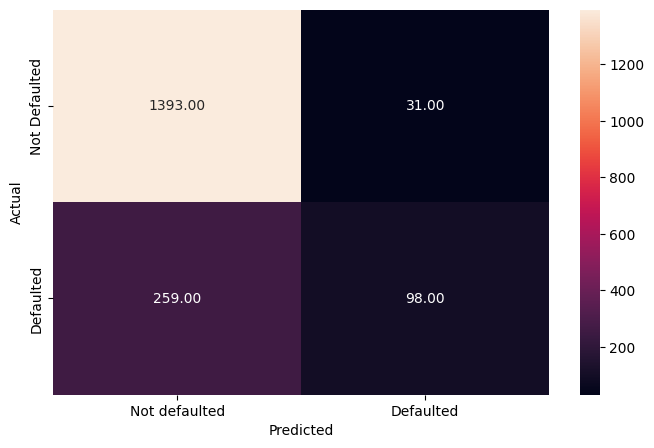

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Expected profit 2694612.650050277 with confidence 0.8378092652169723
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1424
           1       0.75      0.27      0.40       357

    accuracy                           0.84      1781
   macro avg       0.80      0.63      0.65      1781
weighted avg       0.82      0.84      0.80      1781



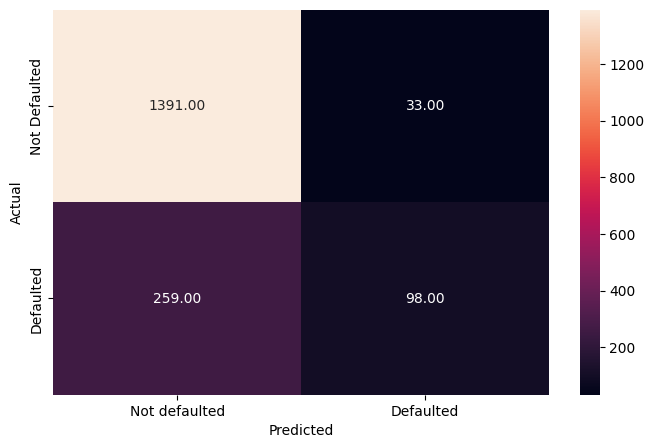

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Expected profit 2694612.650050277 with confidence 0.8378092652169723
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1424
           1       0.75      0.27      0.40       357

    accuracy                           0.84      1781
   macro avg       0.80      0.63      0.65      1781
weighted avg       0.82      0.84      0.80      1781



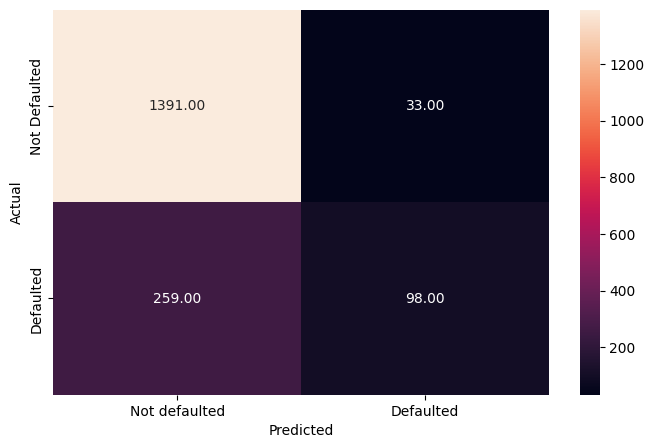

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Expected profit 1760434.3874773076 with confidence 0.8193714654977431
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1424
           1       0.78      0.18      0.30       357

    accuracy                           0.83      1781
   macro avg       0.81      0.58      0.60      1781
weighted avg       0.82      0.83      0.78      1781



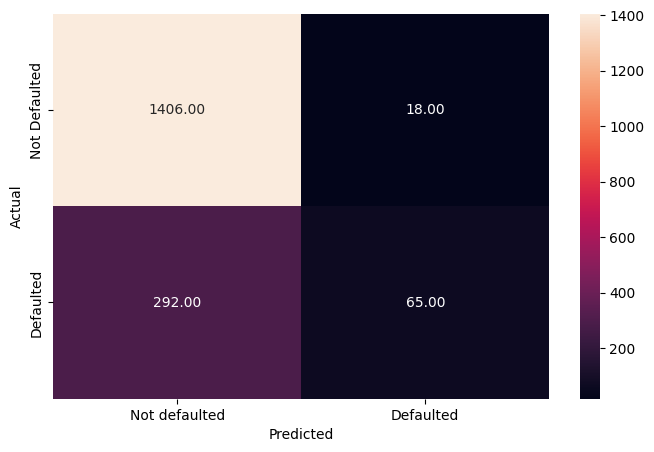

In [128]:
# Define the model
log_reg = LogisticRegression(random_state=1)

# Define the parameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization techniques
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Solvers compatible with l1 and elasticnet penalties
    'max_iter': [500, 1000, 2000, 3000]  # Number of iterations for convergence
}

# Define scoring metric
optimum = ['accuracy', 'f1', 'recall', 'precision']

results = {}  # Dictionary to store all results dynamically

for opt in optimum:
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid,
        scoring=opt,  # Choose your metric here
        cv=5,  # 5-fold cross-validation
        verbose=1,  # Print progress
        n_jobs=-1  # Use all available processors
    )
    
    # Perform the grid search on the training data
    grid_search.fit(x_train, y_train)
    
    # Test the optimized model on the test set
    best_model = grid_search.best_estimator_
    best_model.fit(x_train, y_train)
    y_pred = best_model.predict(x_test)

    # Calculate metrics
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Confusion Matrix to extract FPs and FNs
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Predict probabilities for revenue prediction
    pred_prob = best_model.predict_proba(X_scaled)
    default_model_copy = default_model.copy()
    default_model_copy['prob_default'] = pred_prob[:, 1]

    # Calculate expected profit and confidence
    profit, confidence = calculate_expected_with_confidence(default_model_copy, 'loan_amount_approved')

    # Append results to the DataFrame
    new_row = {
        "Model Name": f"lg_{opt}",
        "Model Type": "Logistic Regression",
        "Grid Search (Yes/No)": "Yes",
        "Recall": recall,
        "Precision": precision,
        "f1": f1,
        "Accuracy": accuracy,
        "FPs": fp,
        "FNs": fn,
        "Revenue Prediction": profit,
        "Confidence": confidence
    }
    model_metrics.loc[len(model_metrics)] = new_row
    print('Expected profit', profit, 'with confidence', confidence)
    metrics_score(y_test, y_pred)

In [129]:
model_metrics

,Model Name,Model Type,Grid Search (Yes/No),Recall,Precision,f1,Accuracy,FPs,FNs,Revenue Prediction,Confidence
0,lg,Logistic Regression,No,0.274510,0.748092,0.401639,0.836047,33,259,2.698671e+06,0.837825
1,lg_accuracy,Logistic Regression,Yes,0.274510,0.759690,0.403292,0.837170,31,259,2.668632e+06,0.837108
2,lg_f1,Logistic Regression,Yes,0.274510,0.748092,0.401639,0.836047,33,259,2.694613e+06,0.837809
3,lg_recall,Logistic Regression,Yes,0.274510,0.748092,0.401639,0.836047,33,259,2.694613e+06,0.837809
4,lg_precision,Logistic Regression,Yes,0.182073,0.783133,0.295455,0.825940,18,292,1.760434e+06,0.819371


#### Observation:
Even GridSearch is not able to provide a satisfactory performance, as is evident from recall scores. The best recall score is the same as the model without GridSearch

However, the best result is for the model optimized for recall

The false positives seem to be primarily driven by credit-related factors (delinquent_credit_lines, debt_to_income_ratio, and major_derogatory_reports) overpowering stabilizing factors like small loan amounts, long credit histories, or stable job types. Addressing these imbalances in the model can improve its predictive accuracy.

### Decision Tree

In [130]:
# Building decision tree model
dt = DecisionTreeClassifier(criterion='entropy', random_state=1)

In [131]:
# Fitting decision tree model
dt.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3323
           1       1.00      1.00      1.00       831

    accuracy                           1.00      4154
   macro avg       1.00      1.00      1.00      4154
weighted avg       1.00      1.00      1.00      4154



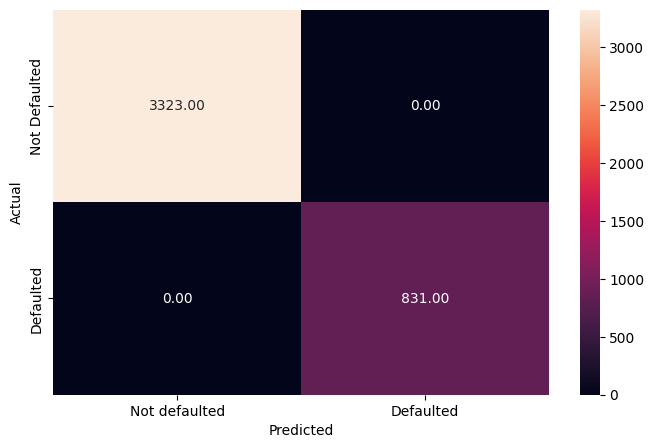

In [132]:
# Checking performance on the training dataset
y_train_pred_dt = dt.predict(x_train)

metrics_score(y_train, y_train_pred_dt)

Total expected revenue: 7501717.5 with confidence of: 1.0
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1424
           1       0.68      0.57      0.62       357

    accuracy                           0.86      1781
   macro avg       0.79      0.75      0.76      1781
weighted avg       0.85      0.86      0.85      1781



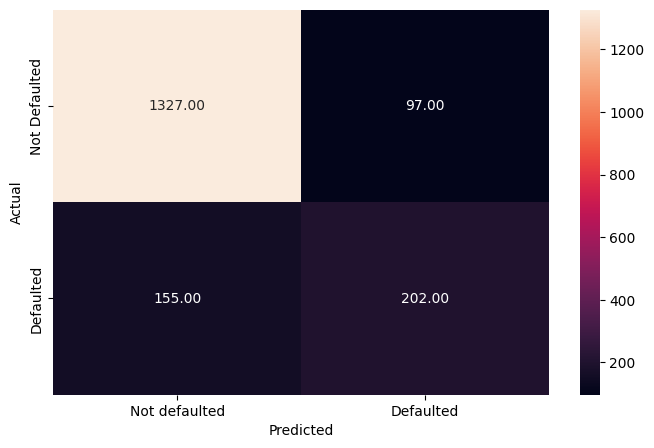

In [133]:
# Checking the performance on the test data
pred_prob_dt = dt.predict_proba(X_scaled)
default_model['prob_default'] = pred_prob_dt[:, 1]  # Column for P(default)
# Calculate profit and loss for the tailored dataset

revenue_dt, confidence_dt = calculate_expected_with_confidence(default_model, 'loan_amount_approved')
print("Total expected revenue:", revenue_dt, 'with confidence of:', confidence_dt)

# Checking performance on the training dataset
y_test_pred_dt = dt.predict(x_test)

metrics_score(y_test, y_test_pred_dt)

In [134]:
cr_dt = classification_report(y_test, y_test_pred_dt, output_dict=True)
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
dt_metrics_compare = {'Model Name': 'dt',
                      'Model Type': 'Decision Tree',
                      'Grid Search (Yes/No)': 'No',
                      'Recall': cr_dt['1']['recall'],
                      'Precision':cr_dt['1']['precision'],
                      'f1': cr_dt['1']['f1-score'],
                      'Accuracy':cr_dt['accuracy'], 
                      'FPs': cm_dt[0][1],
                      'FNs': cm_dt[1][0],
                      'Revenue Prediction': revenue_dt,
                      'Confidence': confidence_dt
                     }
model_metrics.loc[len(model_metrics)] = dt_metrics_compare

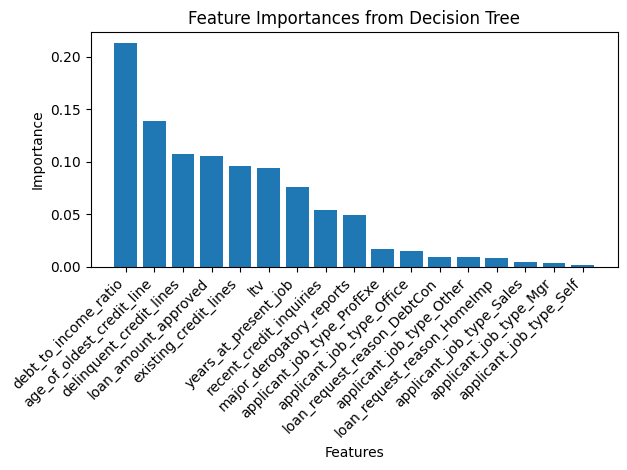

In [135]:
# Retrieve Feature Importances
importances = dt.feature_importances_

# Create a DataFrame for Feature Importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotting with Proper Label Alignment
x_labels = importance_df['Feature']
y_values = importance_df['Importance']

plt.bar(np.arange(len(x_labels)), y_values, align='center')
plt.xticks(np.arange(len(x_labels)), x_labels, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

#### Observation:

Model is overfitting the training data, but the performance on the test data is very good compared to Logistic Regression model
Debt to income ratio is the most important factor is default, while the delinquent credit lines was the most important for Logistic Regression
The importance of the features is in line with general expectations

### **Decision Tree - Hyperparameter Tuning**

* Hyperparameter tuning is tricky in the sense that **there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model**, so we usually resort to experimentation. We'll use Grid search to perform hyperparameter tuning.
* **Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.** 
* **It is an exhaustive search** that is performed on the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.

**Criterion {“gini”, “entropy”}**

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**max_depth** 

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_leaf**

The minimum number of samples is required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

You can learn about more Hyperpapameters on this link and try to tune them. 

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


In [136]:
# Choose the type of classifier
dtree_estimator_grid = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', 0.5],
    'criterion': ['gini', 'entropy']
}

# Define scoring metric
optimum = ['accuracy', 'f1', 'recall', 'precision']

for opt in optimum:
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=dtree_estimator_grid,
        param_grid=parameters,
        scoring=opt,  # Choose your metric here
        cv=5,  # 5-fold cross-validation
        n_jobs=-1  # Use all available processors
    )

    # Perform the grid search on the training data
    grid_search.fit(x_train, y_train)
    
    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print("Best Parameters:", best_params)
    print("Best Cross-Validation Score:", best_score)
    
    # Test the optimized model on the test set
    best_model = grid_search.best_estimator_
    best_model.fit(x_train, y_train)
    test_accuracy = best_model.score(x_test, y_test)

    # Make predictions
    y_grid = best_model.predict(x_test)

    # Calculate metrics
    recall = recall_score(y_test, y_grid)
    precision = precision_score(y_test, y_grid)
    f1 = f1_score(y_test, y_grid)
    accuracy = accuracy_score(y_test, y_grid)
    
    # Confusion Matrix to extract FPs and FNs
    tn, fp, fn, tp = confusion_matrix(y_test, y_grid).ravel()

    # Predict probabilities for revenue prediction
    pred_prob_best = best_model.predict_proba(X_scaled)
    default_model_copy = default_model.copy()
    default_model_copy['prob_default'] = pred_prob_best[:, 1]

    # Calculate expected profit and confidence
    profit, confidence = calculate_expected_with_confidence(default_model_copy, 'loan_amount_approved')
    print("Total expected profit:", profit, "with confidence of:", confidence)

    # Append results to the DataFrame
    new_row = {
        "Model Name": f"dt_{opt}",
        "Model Type": "Decision Tree",
        "Grid Search (Yes/No)": "Yes",
        "Recall": recall,
        "Precision": precision,
        "f1": f1,
        "Accuracy": accuracy,
        "FPs": fp,
        "FNs": fn,
        "Revenue Prediction": profit,
        "Confidence": confidence
    }
    model_metrics.loc[len(model_metrics)] = new_row

Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score: 0.8690417989648122
Total expected profit: 7346832.213055555 with confidence of: 0.9957231114855378
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score: 0.6471139599990672
Total expected profit: 7346832.213055555 with confidence of: 0.9957231114855378
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score: 0.6053026477166149
Total expected profit: 7458707.5 with confidence of: 1.0
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Cross-Validation Score: 0.7650397476463924
Total expected profit: 4874592.316435514 with confidence of: 0.91135133559318

**Observations:**

- The tuned models are performing marginally better in comparison to the model with default values of hyperparameters.
- While these models are giving good results for recall, there is opportunity to improve the overall performance


### **Building a Random Forest Classifier**

**Random Forest is a bagging algorithm where the base models are Decision Trees.** Samples are taken from the training data and on each sample a decision tree makes a prediction. 

**The results from all the decision trees are combined together and the final prediction is made using voting or averaging.**

In [137]:
# Fitting the Random Forest classifier on the training data
rf_estimator = RandomForestClassifier(criterion='entropy', random_state=1)

rf_estimator.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3323
           1       1.00      1.00      1.00       831

    accuracy                           1.00      4154
   macro avg       1.00      1.00      1.00      4154
weighted avg       1.00      1.00      1.00      4154



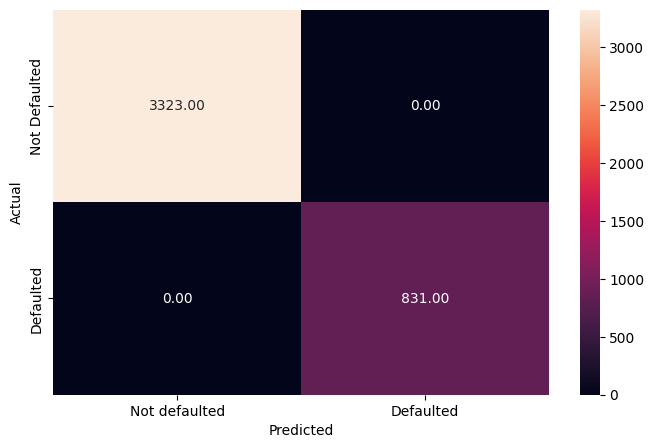

In [138]:
# Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(x_train)

metrics_score(y_train, y_pred_train_rf)

Total expected profit: 5562403.12055 with confidence of: 0.9220488626790229
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1424
           1       0.92      0.63      0.75       357

    accuracy                           0.92      1781
   macro avg       0.92      0.81      0.85      1781
weighted avg       0.92      0.92      0.91      1781



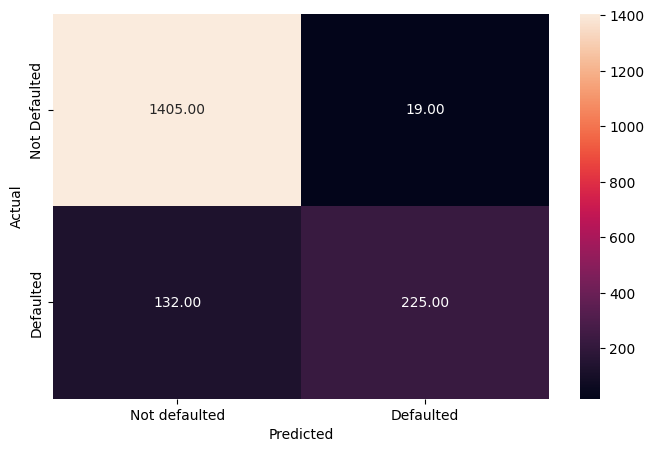

In [139]:
# Checking performance on the testing data
pred_prob_rf = rf_estimator.predict_proba(X_scaled)
default_model_rf = default_model.copy()
default_model_rf['prob_default'] = pred_prob_rf[:, 1]  # Column for P(default)
# Calculate profit and loss for the tailored dataset

revenue_rf, confidence_rf = calculate_expected_with_confidence(default_model_rf, 'loan_amount_approved')
print("Total expected profit:", revenue_rf, 'with confidence of:', confidence_rf)


y_pred_test_rf = rf_estimator.predict(x_test)

metrics_score(y_test, y_pred_test_rf)

In [140]:
cr_rf = classification_report(y_test, y_pred_test_rf, output_dict=True)
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
rf_metrics_compare = {'Model Name': 'rf_estimator',
                      'Model Type': 'Random Forest',
                      'Grid Search (Yes/No)': 'No',
                      'Recall': cr_rf['1']['recall'],
                      'Precision':cr_rf['1']['precision'],
                      'f1': cr_rf['1']['f1-score'],
                      'Accuracy':cr_rf['accuracy'], 
                      'FPs': cm_rf[0][1],
                      'FNs': cm_rf[1][0],
                      'Revenue Prediction': revenue_dt,
                      'Confidence': confidence_dt
                     }
model_metrics.loc[len(model_metrics)] = rf_metrics_compare

In [141]:
model_metrics

,Model Name,Model Type,Grid Search (Yes/No),Recall,Precision,f1,Accuracy,FPs,FNs,Revenue Prediction,Confidence
0,lg,Logistic Regression,No,0.274510,0.748092,0.401639,0.836047,33,259,2.698671e+06,0.837825
1,lg_accuracy,Logistic Regression,Yes,0.274510,0.759690,0.403292,0.837170,31,259,2.668632e+06,0.837108
2,lg_f1,Logistic Regression,Yes,0.274510,0.748092,0.401639,0.836047,33,259,2.694613e+06,0.837809
3,lg_recall,Logistic Regression,Yes,0.274510,0.748092,0.401639,0.836047,33,259,2.694613e+06,0.837809
4,lg_precision,Logistic Regression,Yes,0.182073,0.783133,0.295455,0.825940,18,292,1.760434e+06,0.819371
5,dt,Decision Tree,No,0.565826,0.675585,0.615854,0.858506,97,155,7.501718e+06,1.000000
6,dt_accuracy,Decision Tree,Yes,0.591036,0.674121,0.629851,0.860752,102,146,7.346832e+06,0.995723
7,dt_f1,Decision Tree,Yes,0.591036,0.674121,0.629851,0.860752,102,146,7.346832e+06,0.995723
8,dt_recall,Decision Tree,Yes,0.565826,0.629283,0.595870,0.846154,119,155,7.458708e+06,1.000000
9,dt_precision,Decision Tree,Yes,0.459384,0.803922,0.584670,0.869175,40,193,4.874592e+06,0.911351


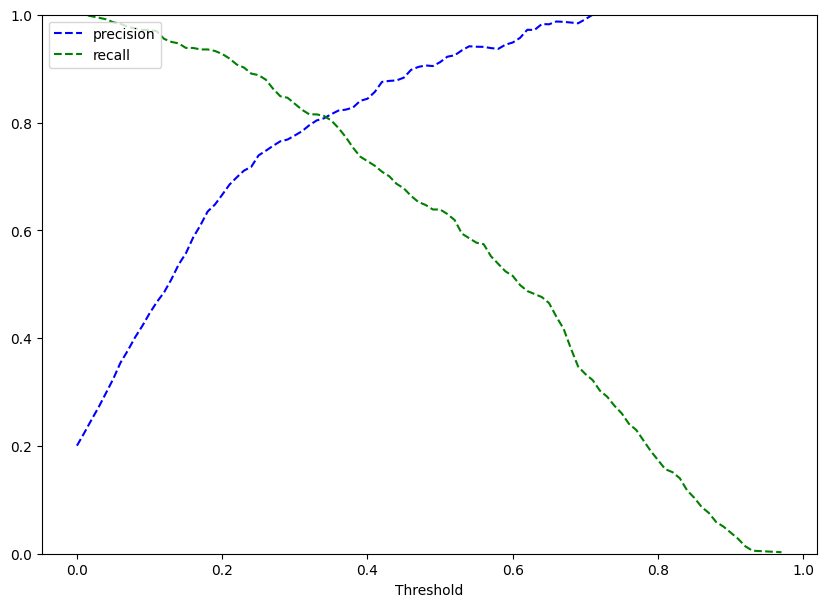

In [65]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities
y_probs = rf_estimator.predict_proba(x_test)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize = (10, 7))

plt.plot(thresholds, precision[:-1], 'b--', label = 'precision')

plt.plot(thresholds, recall[:-1], 'g--', label = 'recall')

plt.xlabel('Threshold')

plt.legend(loc = 'upper left')

plt.ylim([0, 1])

plt.show()

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1424
           1       0.78      0.83      0.80       357

    accuracy                           0.92      1781
   macro avg       0.87      0.89      0.88      1781
weighted avg       0.92      0.92      0.92      1781



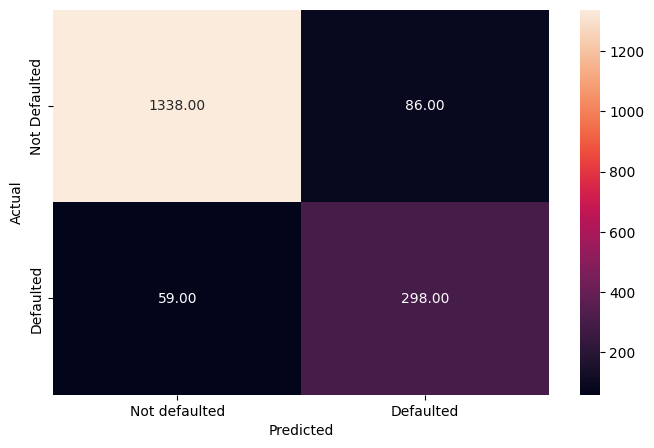

In [66]:
# Adjust the threshold
threshold = 0.3  # Lower than default (0.5)
y_pred_threshold = (y_probs >= threshold).astype(int)

metrics_score(y_test, y_pred_threshold)

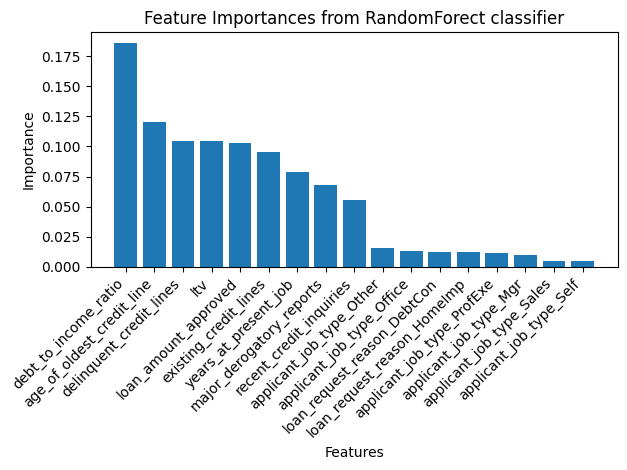

In [67]:
# Retrieve Feature Importances
importances = rf_estimator.feature_importances_

# Create a DataFrame for Feature Importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotting with Proper Label Alignment
x_labels = importance_df['Feature']
y_values = importance_df['Importance']

plt.bar(np.arange(len(x_labels)), y_values, align='center')
plt.xticks(np.arange(len(x_labels)), x_labels, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from RandomForect classifier')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

#### Observation:

Random forest model has a much better overall performance than decisiontree model. The feature importance for top 5 features has also changed slightly, with ltv taking precedence
Adjusting the threshold also substantially improved model performance and should be implemented for the final model as well

### **Random Forest Classifier Hyperparameter Tuning**

In [68]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier()

# Grid of parameters to choose from
params_rf = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False]
}
# Define scoring metric
optimum = ['accuracy', 'f1', 'recall', 'precision']

# for opt in optimum:
#     # Set up GridSearchCV
#     grid_search = GridSearchCV(
#         estimator=rf_estimator_tuned,
#         param_grid=params_rf,
#         scoring=opt,  # Choose your metric here
#         cv=5,  # 5-fold cross-validation
#         n_jobs=-1  # Use all available processors
#     )

#     # Perform the grid search on the training data
#     grid_search.fit(x_train, y_train)
    
#     # Get the best parameters and best score
#     best_params = grid_search.best_params_
#     best_score = grid_search.best_score_
    
#     print("Best Parameters:", best_params)
#     print("Best Cross-Validation Score:", best_score)
    
#     # Test the optimized model on the test set
#     best_model = grid_search.best_estimator_
#     best_model.fit(x_train, y_train)
#     test_accuracy = best_model.score(x_test, y_test)
#     print(f"{opt}:", grid_search.best_score_)

#     pred_prob_best = best_model.predict_proba(X_scaled)
#     default_model['prob_default'] = pred_prob_best[:, 1] # Add predictions to the original dataset

#     profit, confidence = calculate_expected_with_confidence(default_model, 'loan_amount_approved')
#     print("Total expected profit:", profit, 'with confidence of:', confidence)

#     y_grid = best_model.predict(x_test)
#     metrics_score(y_test, y_grid)

In [69]:
# Trigger garbage collection and print the number of objects collected
collected_objects = gc.collect()
print(f"Garbage collector freed {collected_objects} objects.")

Garbage collector freed 123703 objects.


#### Observation:
Tuned RF models are the best-performing among all the models so far, and is giving us scores on the test dataset.

**Model Comparision based on expected revenue and confidence level**
1. Model1 - Logistic Regression with liblinear solver: **Total expected revenue: \$2698670.84 with confidence of: 0.84**
2. Model2 - Best Logistic Regression model with GridSearch: **Total expected revenue: \$2694612.65 with confidence of: 0.84**
3. Model3 - Decisiontree with entropy: **Total expected revenue: \$7501717.5 with confidence of: 1.0**
4. Model4 - Best DecisionTree model with GridSearch: **Total expected revenue: \$7458707.5 with confidence of: 1.0**
5. Model5 - RandomForest with entropy: **Total expected revenue: \$5562512.65485 with confidence of: 0.92**
6. Model6 - Best RandomForest with GridSearch: **Total expected revenue: \$6651963.2723875 with confidence of: 0.97**

**Model Comparision based on metrics**

<div style="display: inline-block">

| **Model**                        | **Precision** | **Recall** | **F1-Score** | **Confidence** |
|----------------------------------|---------------|------------|--------------|----------------|
| **Model 1** (Logistic Regression) | 0.75          | 0.27       | 0.40         | 0.84           |
| **Model 2** (Logistic Regression, GridSearch) | 0.75 | 0.27 | 0.40 | 0.84 |
| **Model 3** (Decision Tree)       | 0.68          | 0.57       | 0.62         | 1.0            |
| **Model 4** (Decision Tree, GridSearch) | 0.63      | 0.57       | 0.60         | 1.0            |
| **Model 5** (Random Forest)       | 0.92          | 0.63       | 0.75         | 0.92           |
| **Model 6** (Random Forest, GridSearch) | 0.91     | 0.70       | 0.79         | 0.97           |

</div>

Overall performance is better for tree based models in comparision with logistic regression. This points to non-linearity in the dataset and existence of outliers, both of which are handled very effectievely by tree based models. 

As can be seen from the above comparision, Model 3 gives the best performance from a revenue standpoint, however, Model 6 has the best performance in terms of the metrics. This descrepency may be because Model 3 performed well against clients with higher loan values. However a more detailed analysis needs to be performed to understand the descrepency. 

There is of course room for improvement in all of the above models by fine tuning the hyperparameters to focus on reducing False Negatives (while not overly sacrificing the recall), as the cost of False Negatives is substantially higher than False positives (i.e. False negatives cost the lender the principle and the interest whereas False positives cost the lender only the interest). This can be achieved by adjusting the weights and fine tuning the threshold to penalize False Negatives more than False Positives.

**2. Refined insights and recommandations:** 

1. Improve Data Quality and capture additional data
> - Encourage applicants to provide missing details, such as job_type and loan_request_reason
> - Use dropdowns and predefined options for categorical data like job_type to minimize typos and inconsistencies.
> - Include gross income and monthly expenses to calculate a more accurate debt-to-income ratio, as this is the most important factor in determining eligibility
> - Collect data on savings, investment portfolios, and other assets to assess overall financial stability
> - Obtain credit scores and histories from reputable bureaus to ensure a consistent, accurate representation of creditworthiness

2. Remove bias in the dataset
> - Ensure that all demographic groups and professions are fairly represented in the data to avoid skewing results
> - Reduce overrepresentation of risky loan types (e.g., debt consolidation loans) by diversifying the dataset

3. Business model
> - Gather borrower feedback on application processes and loan terms to identify areas for business improvement
> - Use the model to identify high-risk borrower segments (e.g., high debt-to-income ratios, multiple derogatory reports)
> - Higher interest rates or stricter loan limits for high-risk borrowers
> - Discounts or incentives for low-risk borrowers
> - Offer customized repayment options for borrowers facing temporary financial difficulties
> - Regular evaluation of bias and fairness to ensure legal and ethical compliance

**Summary**
The loan default problem is heavily influenced by credit history, debt burden, and dataset biases (e.g., debt consolidation). 
The most effective strategies will involve:
> - Robust feature engineering to balance stabilizing and risk-indicating factors.
> - Careful tuning of decision thresholds and class weights to minimize false negatives without inflating false positives.

**3. Proposal for the final solution design:**

While it is tempting to adopt Model 3 or Model 4, due to its performance against revenue metric, it should be noted that these models may not perform well against future customers due to poorer metrics as compared to Model 5 and Model 6.\
So the lender should adopt a refined version of Model 6.\
In summary, for better future default prediction, **Model6 (Random Forest with GridSearch, optimized for f1) is the best choice** due to its strong balance between recall, precision, and F1-score, along with high confidence.\
It is most likely to perform well in minimizing both false negatives (missed defaults) and false positives (incorrect rejections).\
The lender should also **implement the recommendations** from the section above to get the most out of predictive model on an ongoing basis which will benefit the lender in more than one ways.
> - Improve model accuracy and robustness by reducing bias and missing information
> - Ensures fair and personalized loan offerings, improving customer satisfaction
> - Reduces legal and ethical risks by eliminating discriminatory practices
> - Helps mitigate default risk and increases profitability

In [70]:
print('All Working')
# End time
script_end_time = time.time()
total_time = script_end_time - script_start_time
print(f"Total execution time for the script: {total_time:.2f} seconds")

All Working
Total execution time for the script: 15.25 seconds


In [72]:
# Importing the XGBClassifier from the xgboost library
from xgboost import XGBClassifier

# XGBoost Classifier
xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss')

# Fitting the model
xgb.fit(x_train,y_train)

# Model Performance on the test data
xgb_perf_test = model_performance_classification(xgb,x_test,y_test)

xgb_perf_test

,Precision,Recall,Accuracy
0,0.906748,0.828402,0.918585


In [1]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier